# 9.0 Swing+

An attempt at a Swing+ metric.

## Libraries

In [2]:
import logging
import sys
import warnings
import os

import pandas as pd
import numpy as np
from scipy.stats import zscore

from pandas_gbq import read_gbq
from google.oauth2 import service_account

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    PredictionErrorDisplay,
)

from xgboost import XGBRegressor, plot_importance
from pygam import (
    GAM,
    LinearGAM,
    s,
    l,
    te
)

## Setup

In [3]:
# BigQuery
PROJECT_ID = 'ad-fantasy-baseball'
CREDENTIALS = service_account.Credentials.from_service_account_file(os.path.join(os.pardir, './credentials/mlb-db-analysis-user.json'))

In [4]:
# BQ logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [5]:
# Pandas
pd.set_option('display.precision', 4)
pd.options.mode.copy_on_write = True

In [6]:
# Seaborn
sns.set(rc={'figure.figsize': (16, 9)})

## Data

In [7]:
params = {
    'min_date': '2025-03-01'
}

In [8]:
SQL = \
"""
WITH t_statcast AS (
  SELECT
    event_id,
    game_date,
    game_year,
    batter,
    pitcher,
    stand,
    plate_x,
    plate_z,
    bat_speed,
    swing_length,
    attack_angle,
    attack_direction,
    swing_path_tilt,
    intercept_ball_minus_batter_pos_x_inches,
    intercept_ball_minus_batter_pos_y_inches,
    woba_value,
    estimated_woba_using_speedangle,
  FROM
    `ad-fantasy-baseball.core.statcast_extended`
  WHERE
    game_date > '{min_date}'
      AND game_type <> 'S'
      AND description = 'hit_into_play'
      AND events NOT IN ('sac_bunt', 'sac_bunt_double_play', 'catcher_interf')
),
t_players AS (
  SELECT
    MLBID as player_id,
    MLBNAME as player_name
  FROM
    `ad-fantasy-baseball.core.players`
)
SELECT
  t_statcast.*,
  t_batters.player_name AS batter_name,
  t_pitchers.player_name AS pitcher_name,
FROM
  t_statcast
    LEFT JOIN
  t_players AS t_batters
    ON (t_statcast.batter = t_batters.player_id)
    LEFT JOIN
  t_players AS t_pitchers
    ON (t_statcast.pitcher = t_pitchers.player_id)
"""

In [9]:
sql = SQL.format(**params)
df_events = read_gbq(
    sql,
    dialect='standard',
    project_id=PROJECT_ID,
    credentials=CREDENTIALS
)

df_true = df_events.copy()

/Users/anthonydelage/Documents/projects/mlb-db-analysis/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:2689: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


Total time taken 26.56 s.
Finished at 2025-08-26 13:50:27.


In [10]:
df_events.shape

(101984, 19)

## Data prep

In [11]:
float_cols = [
    'plate_x',
    'plate_z',
    'bat_speed',
    'swing_length',
    'attack_angle',
    'attack_direction',
    'swing_path_tilt',
    'intercept_ball_minus_batter_pos_x_inches',
    'intercept_ball_minus_batter_pos_y_inches',
    'woba_value',
    'estimated_woba_using_speedangle'
]
df_events[float_cols] = df_events[float_cols].astype(float).round(4)

In [12]:
# Filters
_min_bat_speed = df_events['bat_speed'] > 60
df_threshold = df_events[_min_bat_speed]

In [13]:
# New fields
df_threshold['plate_x_relative'] = np.where(df_threshold['stand'] == 'R', df_threshold['plate_x'], -df_threshold['plate_x'])
df_threshold['plate_pos'] = df_threshold[['plate_x_relative', 'plate_z']].apply(lambda row: row.to_numpy(), axis=1).tolist()

In [14]:
df_threshold.head(10)

event_id   game_date  game_year  batter pitcher stand  plate_x  \
0   776592.12.5  2025-08-25       2025  666969  667755     R    -0.09   
1   776592.69.3  2025-08-25       2025  666969  445276     R     0.22   
2   776592.52.5  2025-08-25       2025  666969  672282     R     0.35   
3   776592.19.3  2025-08-25       2025  696030  667755     L    -0.45   
4   776592.19.3  2025-08-25       2025  696030  667755     L    -0.45   
5   776592.68.5  2025-08-25       2025  683227  445276     R     0.37   
6   776592.51.4  2025-08-25       2025  683227  672282     R     0.17   
7   776592.67.2  2025-08-25       2025  608369  445276     L     0.14   
8   776592.28.4  2025-08-25       2025  608369  667755     L    -0.05   
10  776592.33.6  2025-08-25       2025  592626  667755     L    -0.21   

    plate_z  bat_speed  swing_length  ...  attack_direction  swing_path_tilt  \
0      2.55       67.7           6.4  ...           10.7270          27.5366   
1      3.19       70.1           7.4  ...           -6.9944          19.4089   
2      1.70       60.4           8.3  ...           -7.9543          28.1860   
3      1.83       71.2           7.6  ...            6.6864          32.2905   
4      1.83       71.2           7.6  ...            6.6864          32.2905   
5      2.87       71.3           6.8  ...           -4.6165          20.1872   
6      3.58       66.6           6.0  ...            4.2153          13.3271   
7      1.95       75.9           7.1  ...          -11.7235          39.6970   
8      2.79       74.2           6.2  ...            5.7230          29.3074   
10     3.48       75.0           7.4  ...          -10.6102          21.4224   

    intercept_ball_minus_batter_pos_x_inches  \
0                                    33.4565   
1                                    35.5502   
2                                    38.3126   
3                                    40.6094   
4                                    40.6094   
5                                    37.6716   
6                                    36.8636   
7                                    35.0539   
8                                    38.8728   
10                                   36.1164   

    intercept_ball_minus_batter_pos_y_inches  woba_value  \
0                                    34.8339         0.0   
1                                    36.3763         0.0   
2                                    41.1170         0.9   
3                                    33.1265         0.0   
4                                    33.1265         0.0   
5                                    37.2312         0.0   
6                                    29.3367         0.0   
7                                    41.6746         0.0   
8                                    30.1465         0.0   
10                                   33.0631         0.9   

    estimated_woba_using_speedangle      batter_name   pitcher_name  \
0                             0.875    Adolis Garcia   Jose Soriano   
1                             0.006    Adolis Garcia  Kenley Jansen   
2                             0.917    Adolis Garcia   Reid Detmers   
3                             0.269  Alejandro Osuna   Jose Soriano   
4                             0.269  Alejandro Osuna   Jose Soriano   
5                             0.036             None  Kenley Jansen   
6                             0.000             None   Reid Detmers   
7                             0.062     Corey Seager  Kenley Jansen   
8                             0.349     Corey Seager   Jose Soriano   
10                            0.482     Joc Pederson   Jose Soriano   

   plate_x_relative      plate_pos  
0             -0.09  [-0.09, 2.55]  
1              0.22   [0.22, 3.19]  
2              0.35    [0.35, 1.7]  
3              0.45   [0.45, 1.83]  
4              0.45   [0.45, 1.83]  
5              0.37   [0.37, 2.87]  
6              0.17   [0.17, 3.58]  
7             -0.14  [-0.14, 1.95]  
8              0.

In [16]:
df_threshold.describe(percentiles=[.05, .1, .25, .5, .75, .9, .95])

game_year     plate_x     plate_z   bat_speed  swing_length  \
count    93841.0  93841.0000  93841.0000  93841.0000    93841.0000   
mean      2025.0     -0.0020      2.3893     72.0275        7.2363   
std          0.0      0.5173      0.5572      4.7442        0.6889   
min       2025.0     -2.2700      0.2400     60.1000        4.7000   
5%        2025.0     -0.8500      1.4800     63.8000        6.1000   
10%       2025.0     -0.6700      1.6700     65.7000        6.3000   
25%       2025.0     -0.3700      2.0000     68.9000        6.8000   
50%       2025.0      0.0000      2.3800     72.1000        7.3000   
75%       2025.0      0.3600      2.7700     75.2000        7.7000   
90%       2025.0      0.6800      3.1100     77.9000        8.1000   
95%       2025.0      0.8500      3.3100     79.7000        8.3000   
max       2025.0      2.0700      5.2700     88.0000       12.0000   

       attack_angle  attack_direction  swing_path_tilt  \
count    93841.0000        93841.0000       93841.0000   
mean         8.8114            0.1606          31.9127   
std          8.3709           12.0260           6.6962   
min        -46.1103          -61.5354           2.4736   
5%          -5.5389          -18.9008          20.8356   
10%         -2.0384          -14.8607          23.3622   
25%          3.5562           -8.0248          27.4668   
50%          9.2700            0.0057          31.9018   
75%         14.4725            8.2037          36.4190   
90%         18.9287           15.5755          40.4217   
95%         21.6665           19.9476          42.8184   
max         79.0522          171.8325          69.3730   

       intercept_ball_minus_batter_pos_x_inches  \
count                                93805.0000   
mean                                    36.9212   
std                                      6.3161   
min                                     13.4167   
5%                                      26.5531   
10%                                     28.7138   
25%                                     32.4770   
50%                                     36.9102   
75%                                     41.3372   
90%                                     45.1632   
95%                                     47.3721   
max                                     61.2829   

       intercept_ball_minus_batter_pos_y_inches  woba_value  \
count                                93805.0000  93841.0000   
mean                                    30.1811      0.3727   
std                                      7.6996      0.5753   
min                                     -1.7508      0.0000   
5%                                      17.8351      0.0000   
10%                                     20.5421      0.0000   
25%                                     24.9645      0.0000   
50%                                     29.9882      0.0000   
75%                                     35.2661      0.9000   
90%                                     40.1269      1.2500   
95%                                     43.1062      1.6000   
max                                     64.3945      2.0000   

       estimated_woba_using_speedangle  plate_x_relative  
count                       93437.0000        93841.0000  
mean                            0.3799            0.0620  
std                             0.4022            0.5135  
min                             0.0000           -1.9700  
5%                              0.0050           -0.7900  
10%                             0.0140           -0.6100  
25%                             0.0740           -0.3000  
50%                             0.2440            0.0700  
75%                             0.5680            0.4200  
90%                             0.8860            0.7300  
95%                             1.1020            0.9000  
max                             2.0340            2.2700

## Exploration

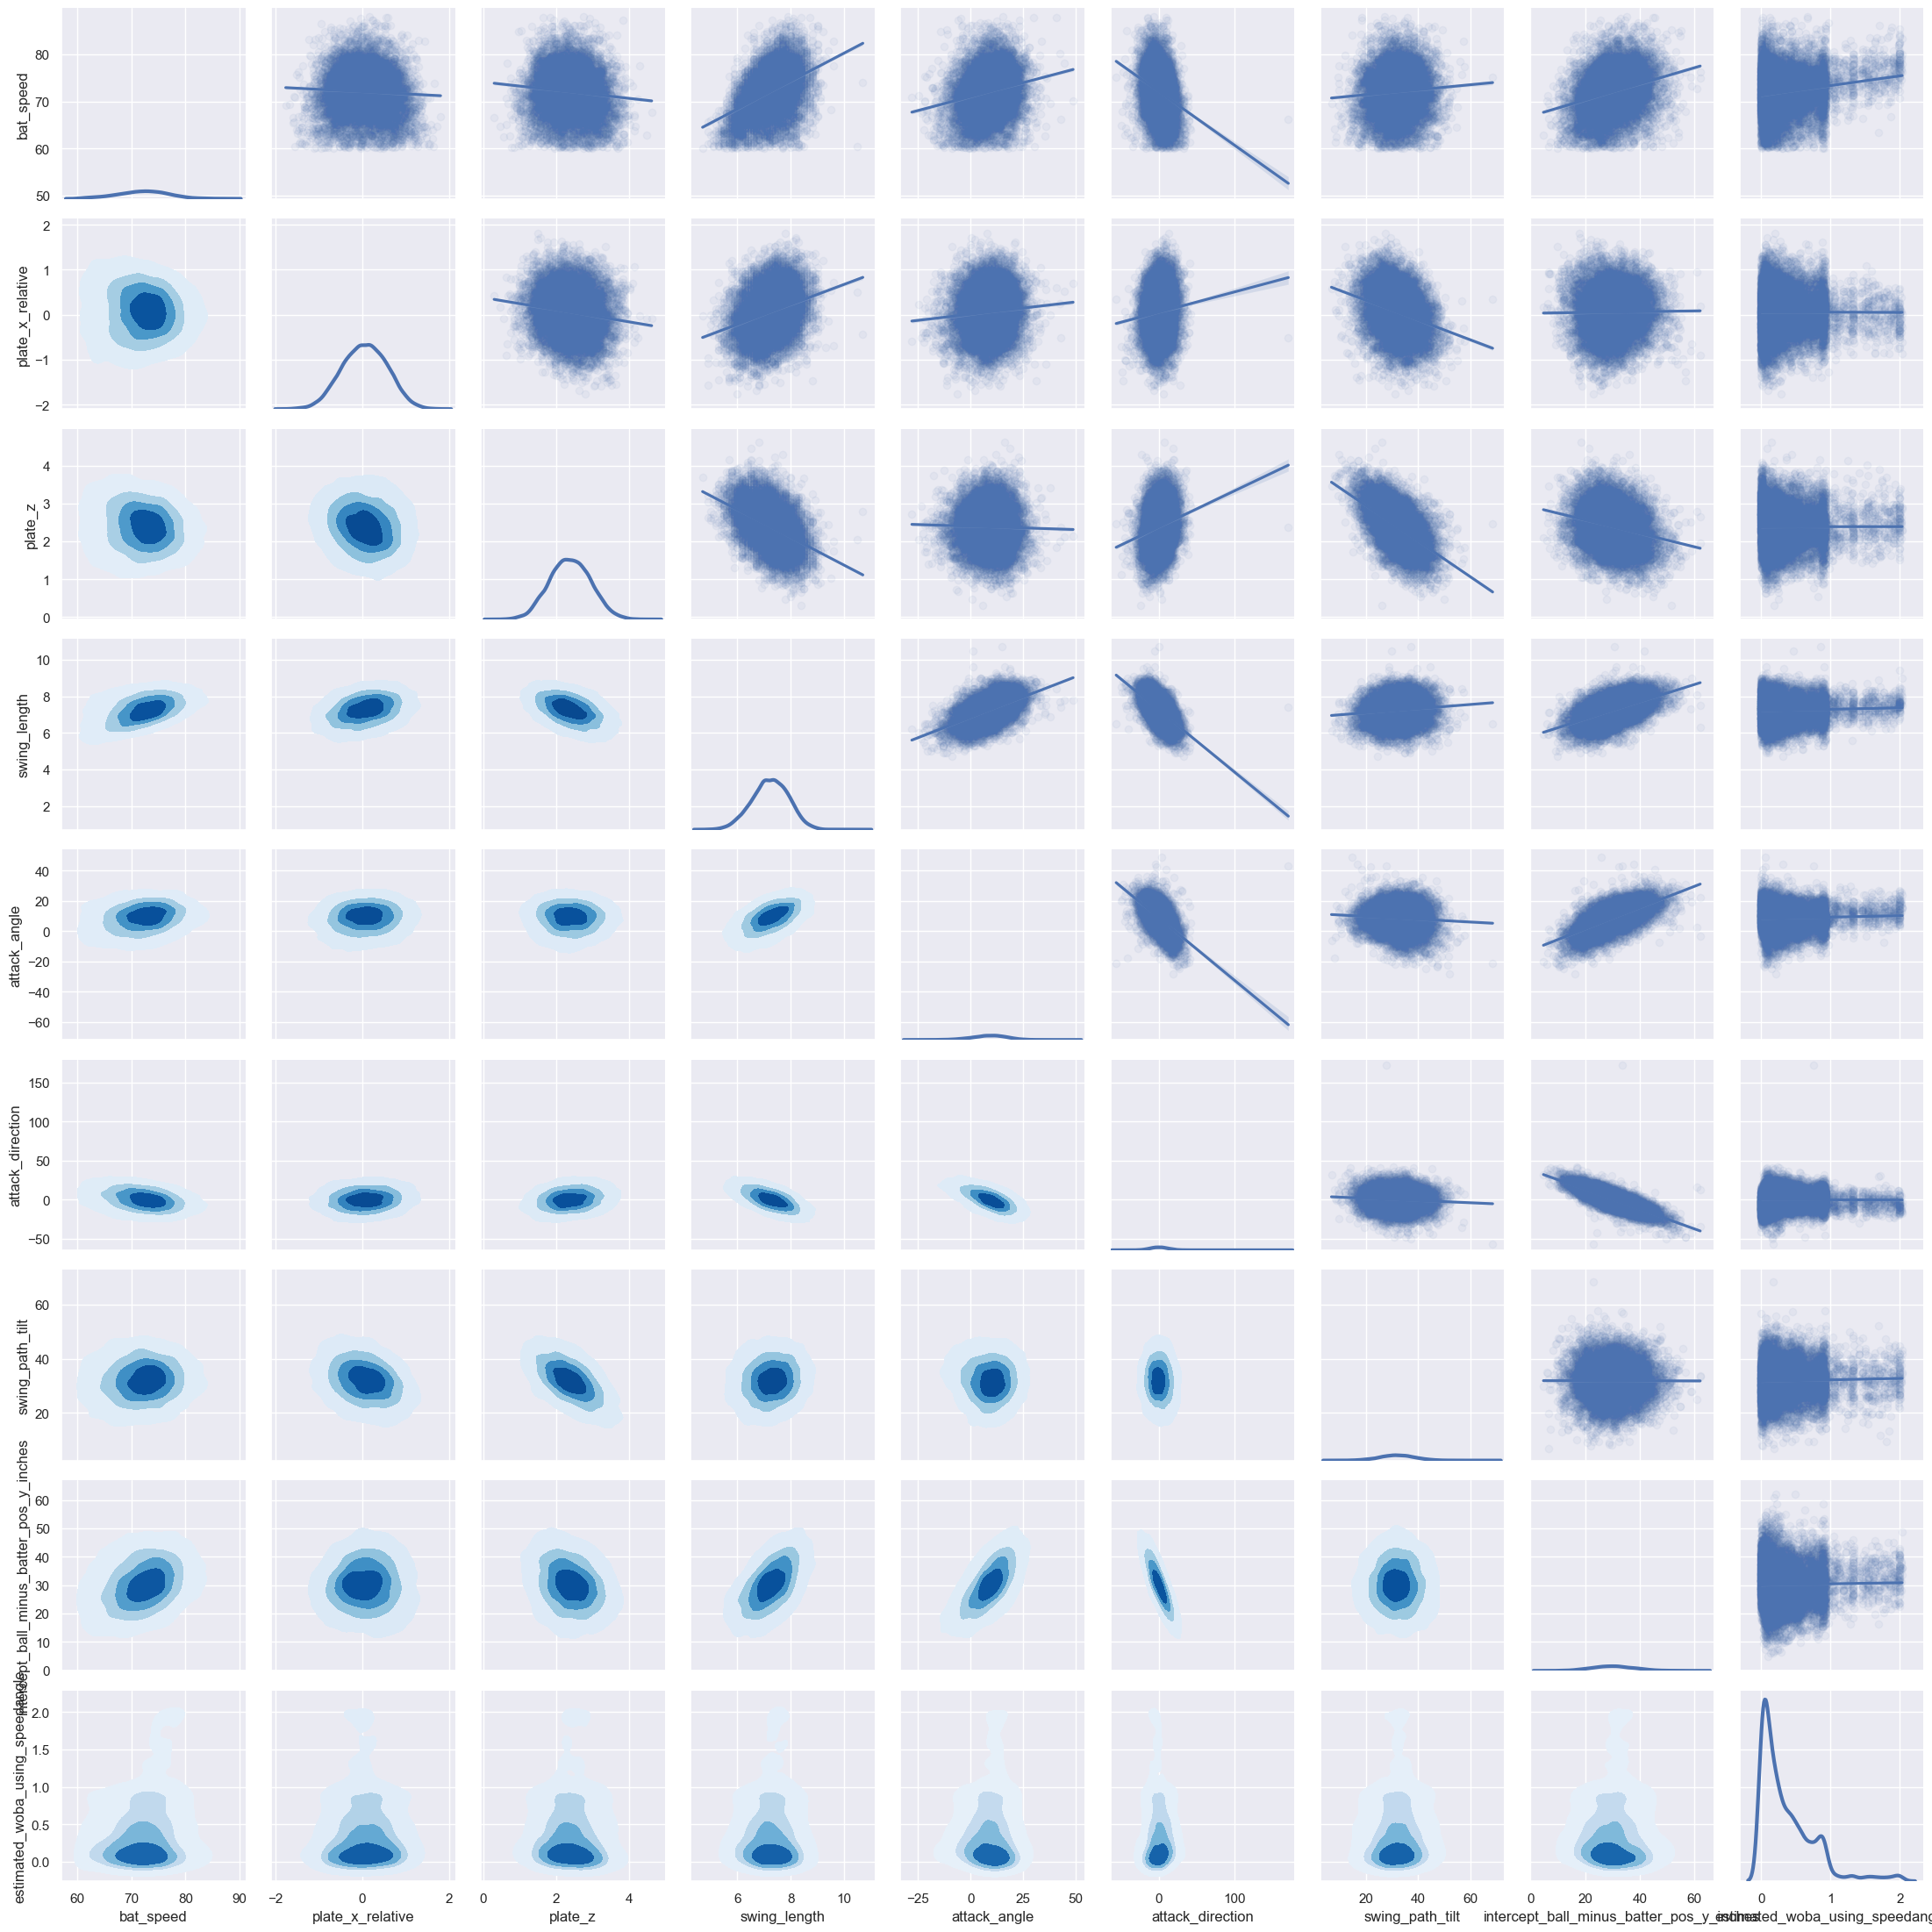

In [ ]:
pair_columns = [
    'bat_speed',
    'plate_x_relative',
    'plate_z',
    'swing_length',
    'attack_angle',
    'attack_direction',
    'swing_path_tilt',
    'intercept_ball_minus_batter_pos_y_inches',
    'estimated_woba_using_speedangle'
]
df_pair = df_threshold[pair_columns].sample(10000)

pair_g = sns.PairGrid(df_pair)
pair_g = pair_g.map_upper(sns.regplot, scatter_kws={'alpha': 0.05})
pair_g = pair_g.map_lower(sns.kdeplot, cmap='rocket', fill=True, thresh=0.05, n_levels=10)
pair_g = pair_g.map_diag(sns.kdeplot, lw=3, legend=False)

In [18]:
sz_limits_z = [1.7, 3.3]
sz_limits_x = [-0.75, 0.75]

sz_bins_n_z = 21
sz_bins_n_x = 15

sz_bins_z = np.round(np.linspace(sz_limits_z[0], sz_limits_z[1], sz_bins_n_z), 3)
sz_bins_x = np.round(np.linspace(sz_limits_x[0], sz_limits_x[1], sz_bins_n_x), 3)

In [19]:
def bin_plate_coordinates(col, bins):
    index = np.digitize(col, bins, right=True)
    if index == 0:
        return
    elif index == len(bins):
        return
    else:
        return bins[index - 1]

df_threshold['plate_z_binned'] = df_threshold['plate_z'].apply(lambda x: bin_plate_coordinates(x, sz_bins_z))
df_threshold['plate_x_binned'] = df_threshold['plate_x_relative'].apply(lambda x: bin_plate_coordinates(x, sz_bins_x))

In [20]:
df_bins = df_threshold.groupby(['plate_z_binned', 'plate_x_binned']).agg(
    n_events=('event_id', 'count'),
    mean_bat_speed=('bat_speed', 'mean'),
    mean_swing_length=('swing_length', 'mean'),
    mean_attack_angle=('attack_angle', 'mean'),
    mean_attack_direction=('attack_direction', 'mean'),
    mean_swing_path_tilt=('swing_path_tilt', 'mean'),
    mean_intercept_ball_minus_batter_pos_y_inches=('intercept_ball_minus_batter_pos_y_inches', 'mean'),
    mean_woba_value=('woba_value', 'mean'),
    mean_xwoba_value=('estimated_woba_using_speedangle', 'mean')
).reset_index()

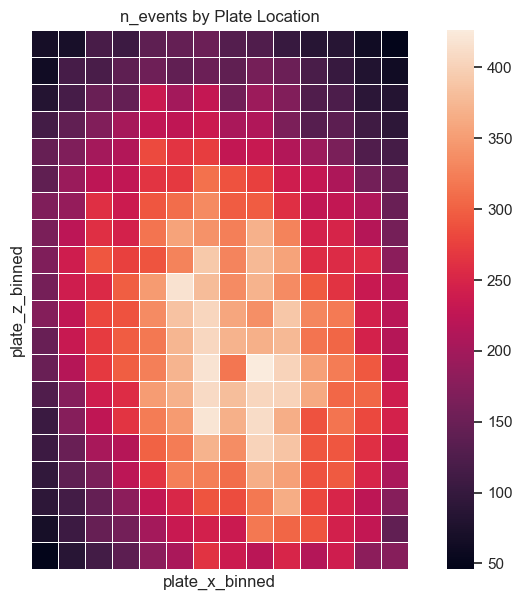

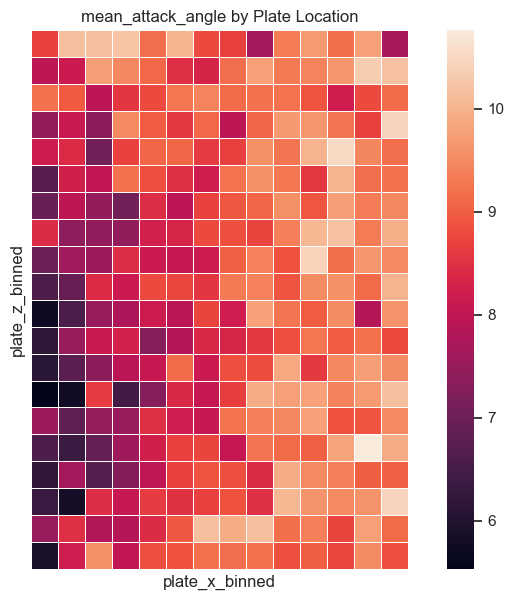

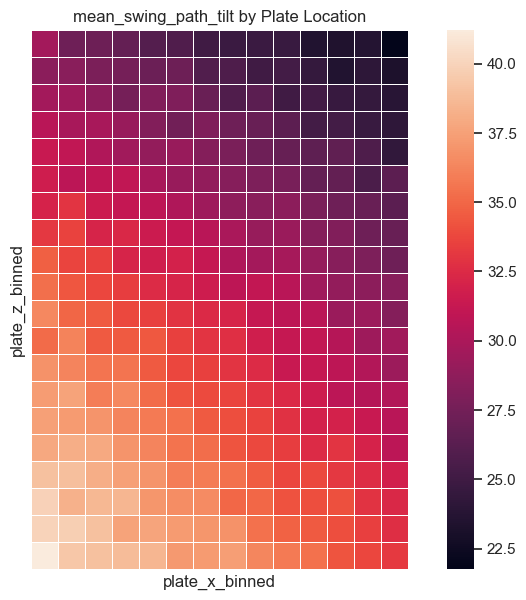

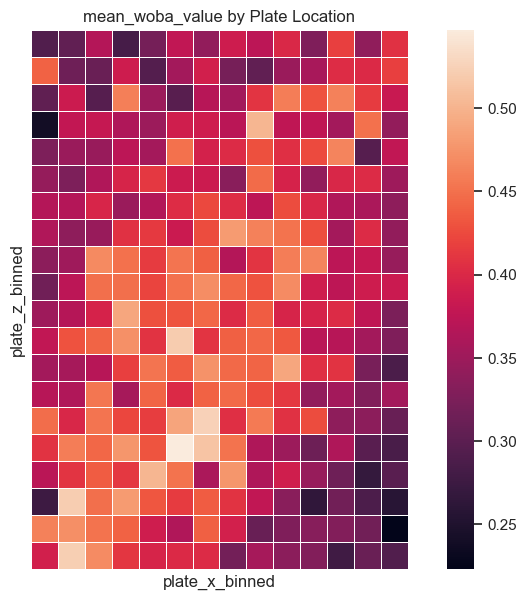

In [21]:
metrics = [
    'n_events',
    'mean_bat_speed',
    'mean_swing_length',
    'mean_attack_angle',
    'mean_attack_direction',
    'mean_swing_path_tilt',
    'mean_intercept_ball_minus_batter_pos_y_inches',
    'mean_woba_value',
    'mean_xwoba_value'
]

for metric in metrics:
    pivot = df_bins.pivot(index='plate_z_binned', columns='plate_x_binned', values=metric)
    plt.figure(figsize=(10, 7))
    ax = sns.heatmap(
        pivot,
        annot=False,
        cmap='rocket',
        cbar=True,
        linewidths=0.5,
        linecolor='white',
        square=True
    )
    ax.invert_yaxis()  # Flip y axis so values are ascending
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title(f"{metric} by Plate Location")
    plt.xlabel("plate_x_binned")
    plt.ylabel("plate_z_binned")
    plt.show()

## Modeling

In [22]:
def train_and_evaluate_xgb(
        df,
        label,
        features,
        model=None,
        resampler=None,
        test_size=0.2
    ):
    
    # Remove any NAs
    cols = features + [label]
    _df = df[cols].dropna(axis=0, how='any')
    
    # Define X and y arrays
    X = _df[features].to_numpy()
    y = _df[label].to_numpy()
    
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
        
    # Resample the data
    if resampler is not None:
        X_res, y_res = resampler.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train
                
    # Train the model
    if model is None:
        model = XGBRegressor(eval_metric='rmsle')
    
    param_grid = {
        "max_depth": [4, 5, 6],
        "n_estimators": [500, 600, 700],
        "learning_rate": [0.005, 0.01]
    }

    search = GridSearchCV(model, param_grid, cv=5, scoring="neg_mean_squared_log_error").fit(X_res, y_res)
    
    search_results = pd.DataFrame(search.cv_results_)
    columns = [column for column in search_results if column.startswith('param_')]
    columns.append("mean_test_score")
    columns.append("rank_test_score")
    # convert mean_test_score to RMSLE and add to table
    search_results["RMSLE"] = np.sqrt(-search_results["mean_test_score"])
    columns.append("RMSLE")
    search_results[columns].sort_values(by='mean_test_score', ascending=False)

    print(f"The best hyperparameters are:\n{search.best_params_}")

    best_model = XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                              n_estimators = search.best_params_["n_estimators"],
                              max_depth = search.best_params_["max_depth"],
                              eval_metric = 'rmsle')

    best_model.fit(X_res, y_res)
    best_model.get_booster().feature_names = features

    # Test the model against the held over test set
    y_pred = best_model.predict(X_test)
    
    # Model metrics
    print("\nR2 score: {:3.3f}".format(r2_score(y_test, y_pred)))
    print("\nMAE score: {:3.3f}".format(mean_absolute_error(y_test, y_pred)))
    print("\nMSE score: {:3.3f}".format(mean_squared_error(y_test, y_pred)))

    # Prediction error plot
    display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
    display.plot()
    plt.show()

    # Feature importance plot
    fig, ax = plt.subplots(figsize=(12,6))
    plot_importance(best_model, max_num_features=10, ax=ax)
    plt.show();
    
    return best_model

In [23]:
def train_and_evaluate_gam(
        df,
        label,
        features,
        model=None,
        constraints=None,
        lam=None,
        intercept=True,
        n_splines=10,
        resampler=None,
        test_size=0.2
    ):
    
    # Remove any NAs
    cols = features + [label]
    _df = df[cols].dropna(axis=0, how='any')

    # Handle None inputs
    if constraints is None:
        constraints = [None] * len(features)
        
    if lam is None:
        lam = np.logspace(-3, 3, 11)
    
    # Define X and y arrays
    X = _df[features].to_numpy()
    y = _df[label].to_numpy()
    
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
        
    # Resample the data
    if resampler is not None:
        X_res, y_res = resampler.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train
                
    # Train the model
    if model is None:
        model = LinearGAM(n_splines=n_splines, fit_intercept=intercept)
    
    model.gridsearch(
        X_res,
        y_res,
        keep_best=True,
        return_scores=True,
        constraints=constraints,
        lam=lam
    )

    num_terms = [ term for i, term in enumerate(model.terms) if not (term.istensor or term.isintercept) ]
    ten_terms = [ term for i, term in enumerate(model.terms) if term.istensor ]
    
    # Print GAM summary
    model.summary()
    
    # Plot individual features
    # Spline and factor terms
    if len(num_terms) > 0:
        plt.rcParams['figure.figsize'] = (28, 8)
        fig, axs = plt.subplots(1, len(num_terms))
        ax_idx = 0
            
        for i, term in enumerate(model.terms):
            if term.isintercept or term.istensor:
                continue
                
            XX = model.generate_X_grid(term=i)
            pdep, confi = model.partial_dependence(term=i, X=XX, width=0.9)

            if len(num_terms) > 1:
                ax = axs[ax_idx]
                ax_idx += 1
            else:
                ax = axs

            ax.plot(XX[:, term.feature], pdep)
            ax.plot(XX[:, term.feature], confi, c='r', ls='--')
            ax.set_title(term.feature)

        plt.show()
    
    # Tensor terms
    if len(ten_terms) > 0:
        plt.rcParams['figure.figsize'] = (12, 8)
        
        for i, term in enumerate(model.terms):
            if not term.istensor:
                continue

            XX = model.generate_X_grid(term=i, meshgrid=True)
            Z = model.partial_dependence(term=i, X=XX, meshgrid=True)

            ax = plt.axes(projection='3d')
            ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')
            plt.show()

    # Test the model against the held over test set
    y_pred = model.predict(X_test)
    
        # Model metrics
    print("\nR2 score: {:3.3f}".format(r2_score(y_test, y_pred)))
    print("\nMAE score: {:3.3f}".format(mean_absolute_error(y_test, y_pred)))
    print("\nMSE score: {:3.3f}".format(mean_squared_error(y_test, y_pred)))

    # Prediction error plot
    display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
    display.plot()
    plt.show()
    
    return model

In [24]:
woba_xgb_1 = train_and_evaluate_xgb(
    df=df_threshold,
    label='woba_value',
    features=[
        'bat_speed',
        'attack_angle',
        'attack_direction'
    ]
)

The best hyperparameters are:
{'learning_rate': 0.005, 'max_depth': 4, 'n_estimators': 600}

R2 score: 0.031

MAE score: 0.488

MSE score: 0.315


In [25]:
woba_xgb_2 = train_and_evaluate_xgb(
    df=df_threshold,
    label='woba_value',
    features=[
        'bat_speed',
        'swing_path_tilt',
    ]
)

The best hyperparameters are:
{'learning_rate': 0.005, 'max_depth': 4, 'n_estimators': 500}

R2 score: 0.014

MAE score: 0.493

MSE score: 0.321


The best hyperparameters are:
{'learning_rate': 0.005, 'max_depth': 4, 'n_estimators': 500}

R2 score: 0.008

MAE score: 0.495

MSE score: 0.323


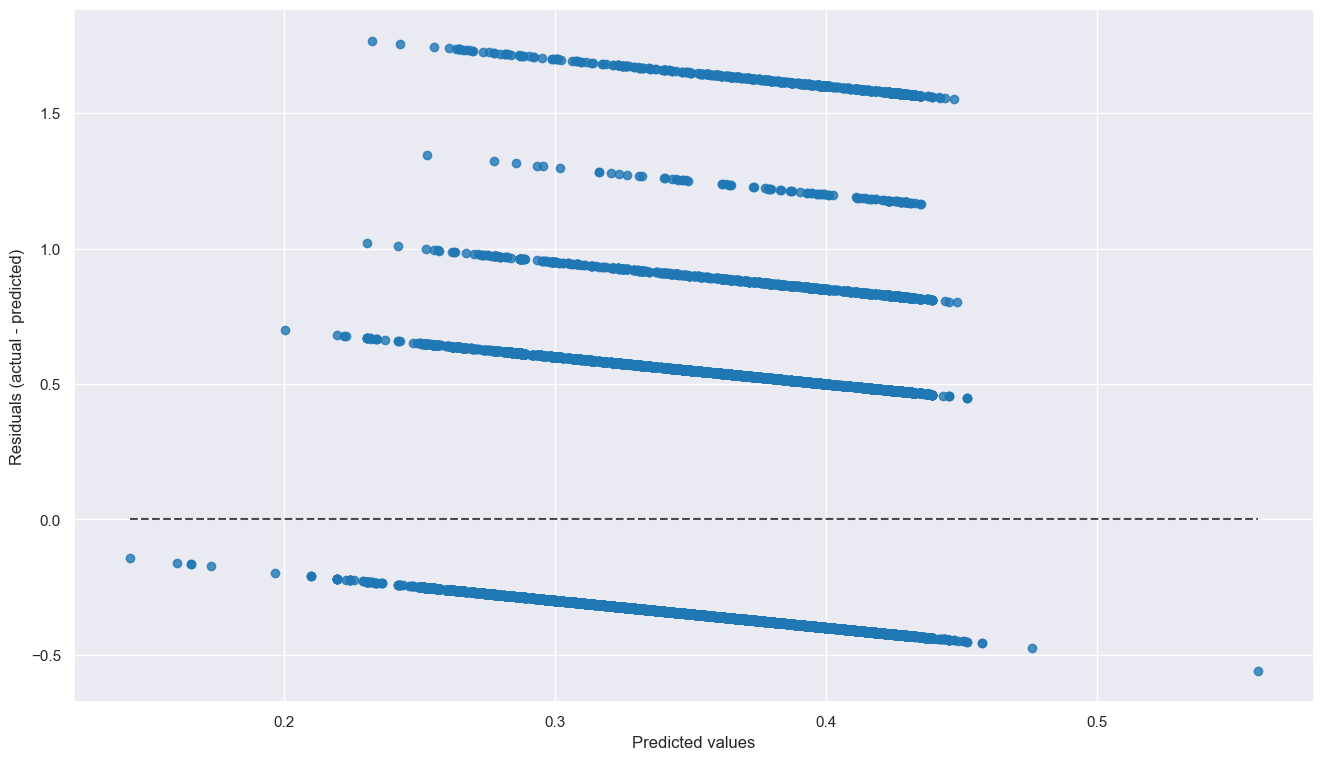

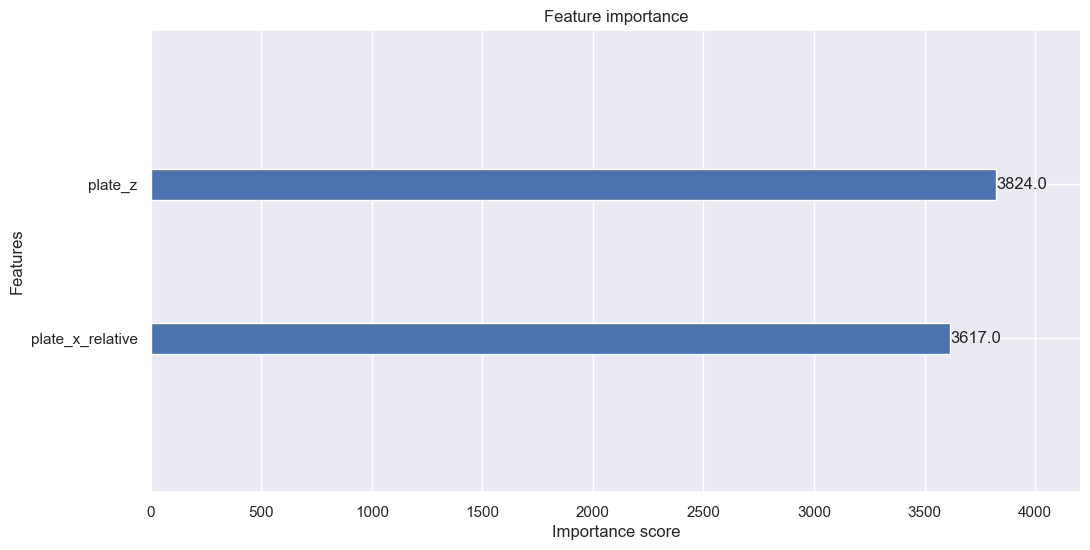

In [26]:
woba_xgb_3 = train_and_evaluate_xgb(
    df=df_threshold,
    label='woba_value',
    features=[
        'plate_x_relative',
        'plate_z'
    ]
)

The best hyperparameters are:
{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}

R2 score: 0.057

MAE score: 0.298

MSE score: 0.154


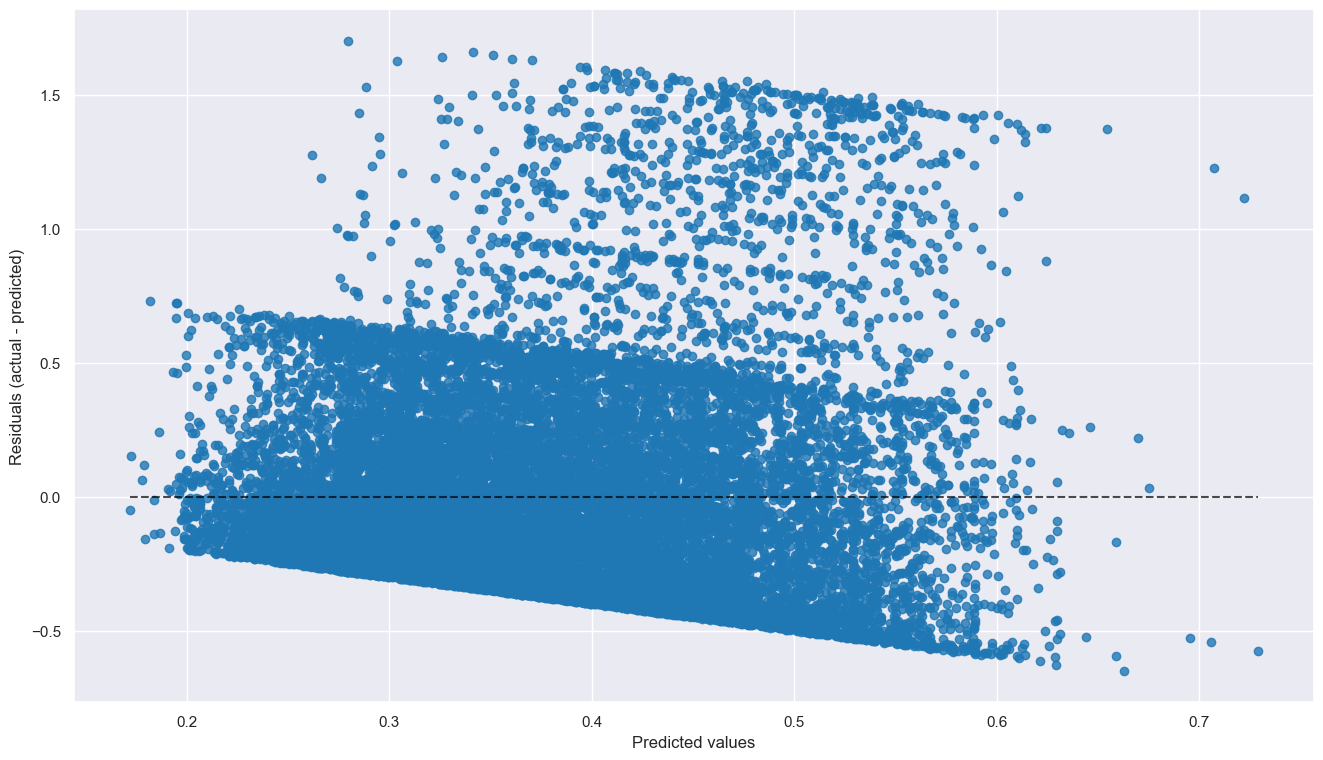

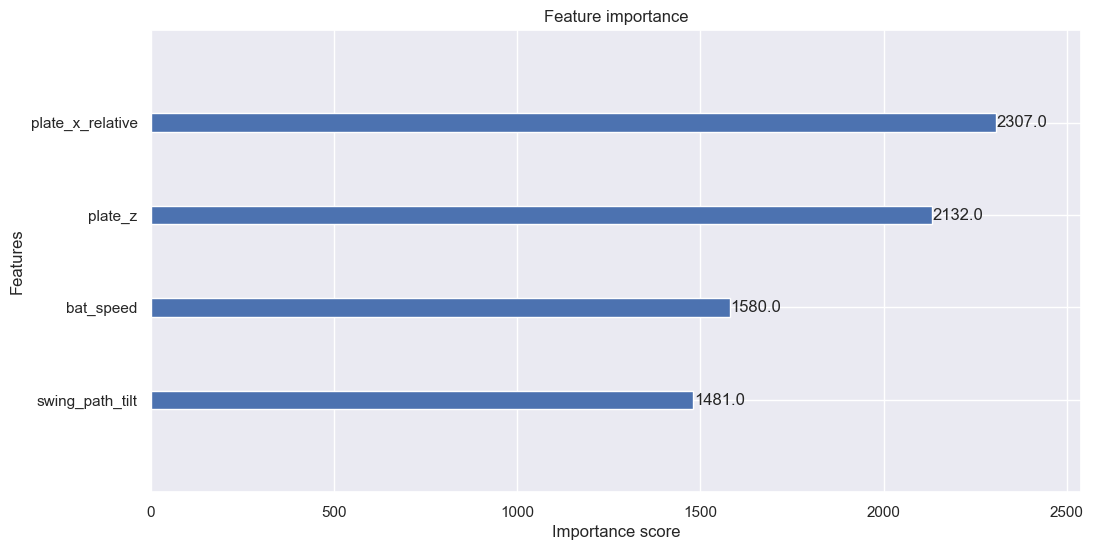

In [27]:
xwoba_xgb_1 = train_and_evaluate_xgb(
    df=df_threshold,
    label='estimated_woba_using_speedangle',
    features=[
        'bat_speed',
        'swing_path_tilt',
        'plate_x_relative',
        'plate_z'
    ]
)

The best hyperparameters are:
{'learning_rate': 0.005, 'max_depth': 4, 'n_estimators': 700}

R2 score: 0.019

MAE score: 0.491

MSE score: 0.319


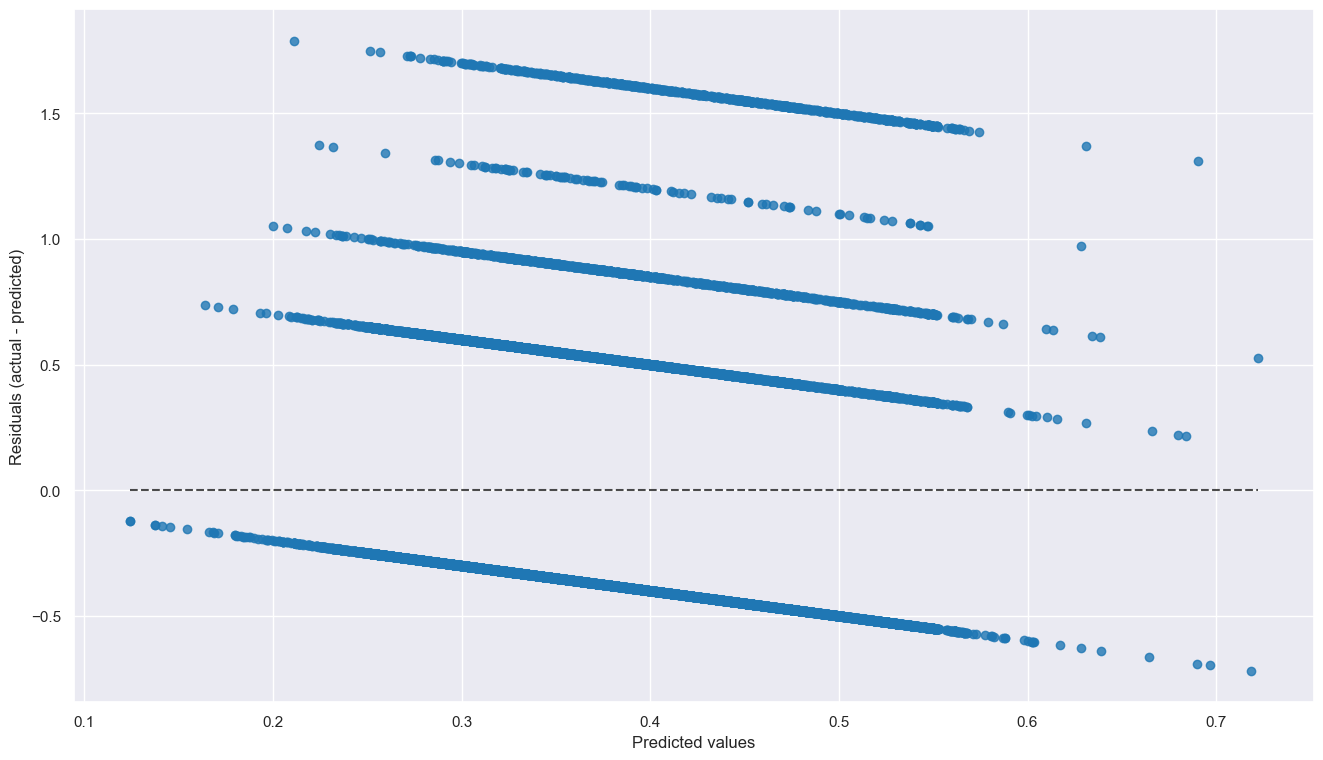

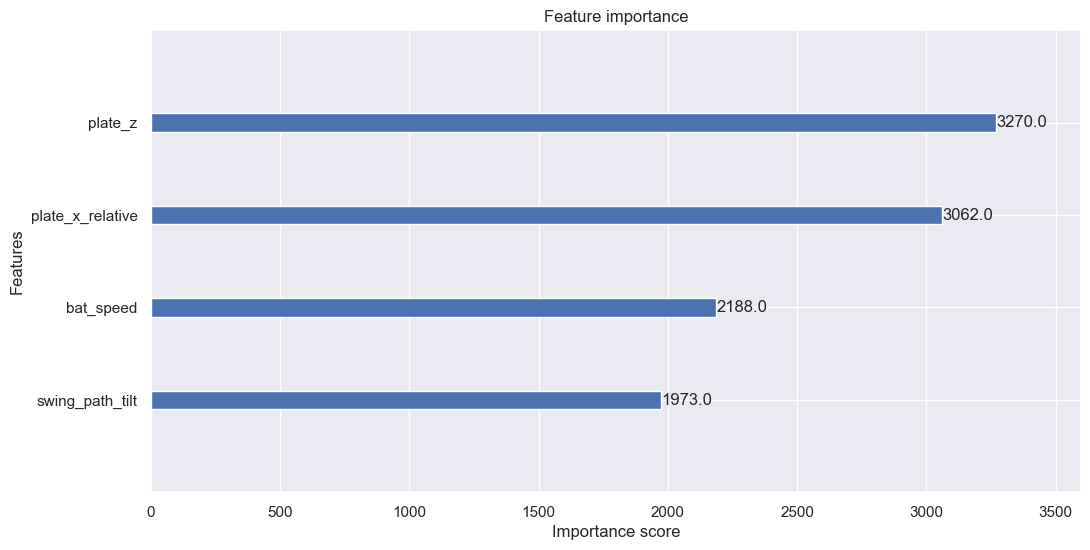

In [28]:
woba_xgb_4_features = [
    'bat_speed',
    'swing_path_tilt',
    'plate_x_relative',
    'plate_z'
]

woba_xgb_4 = train_and_evaluate_xgb(
    df=df_threshold,
    label='woba_value',
    features=woba_xgb_4_features
)

The best hyperparameters are:
{'learning_rate': 0.005, 'max_depth': 4, 'n_estimators': 500}

R2 score: 0.015

MAE score: 0.511

MSE score: 0.340


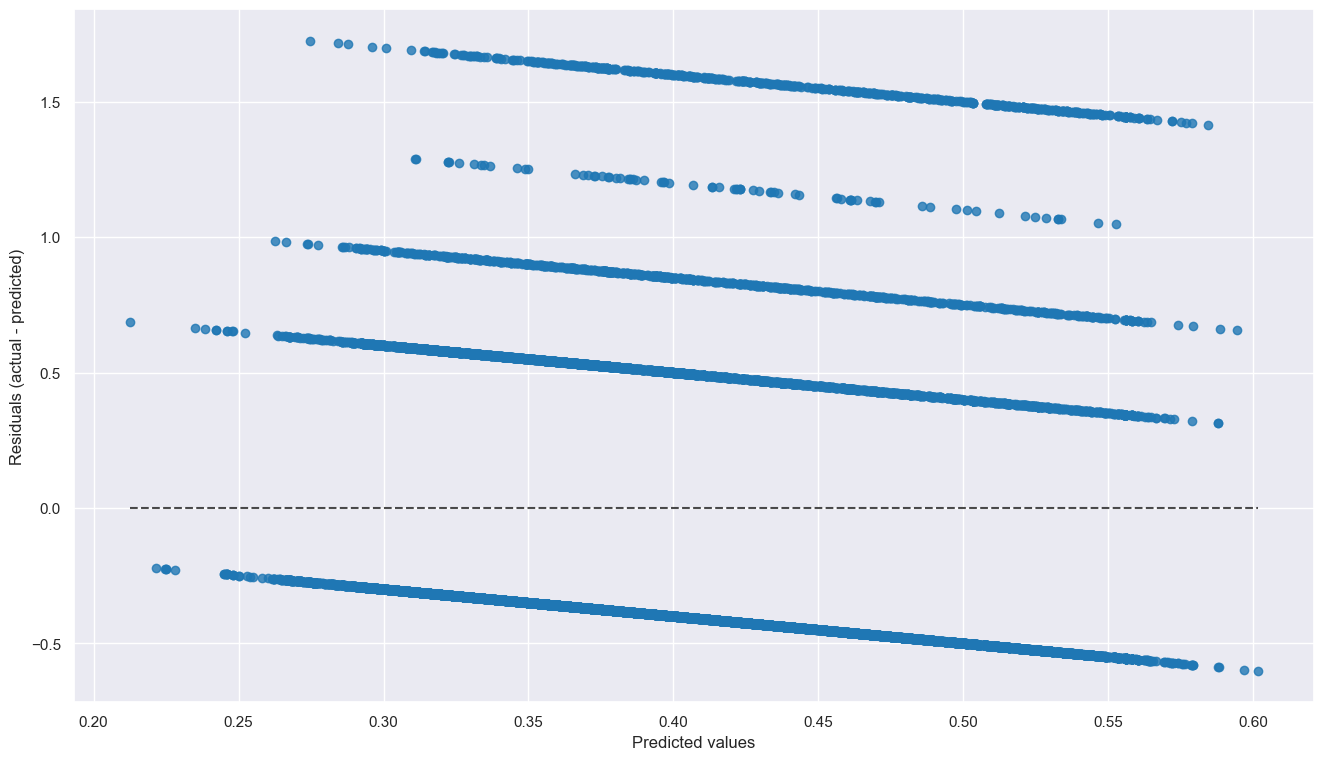

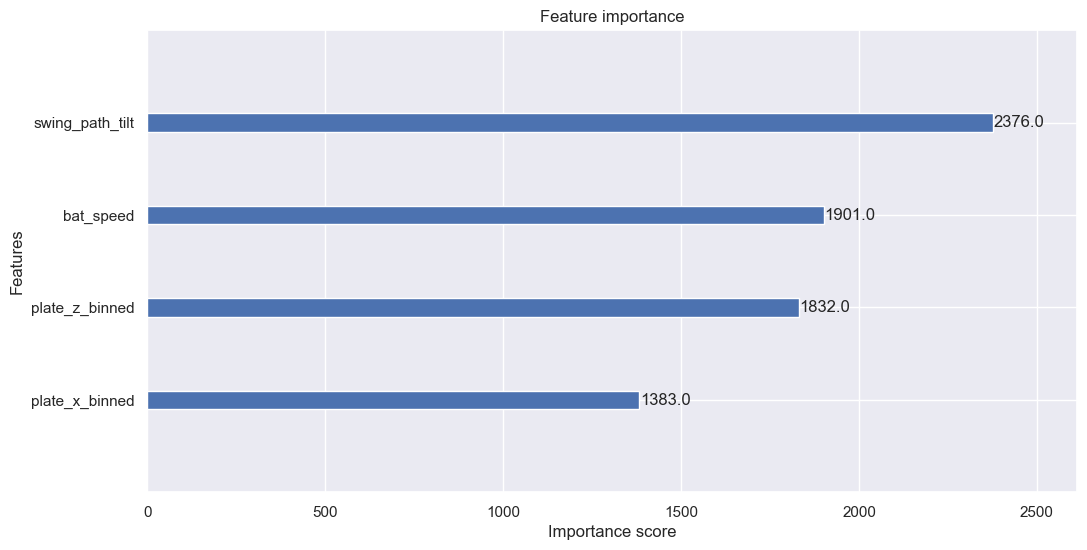

In [29]:
woba_xgb_5_features = [
    'bat_speed',
    'swing_path_tilt',
    'plate_x_binned',
    'plate_z_binned'
]

woba_xgb_5 = train_and_evaluate_xgb(
    df=df_threshold,
    label='woba_value',
    features=woba_xgb_5_features
)

The best hyperparameters are:
{'learning_rate': 0.005, 'max_depth': 5, 'n_estimators': 700}

R2 score: 0.033

MAE score: 0.487

MSE score: 0.313


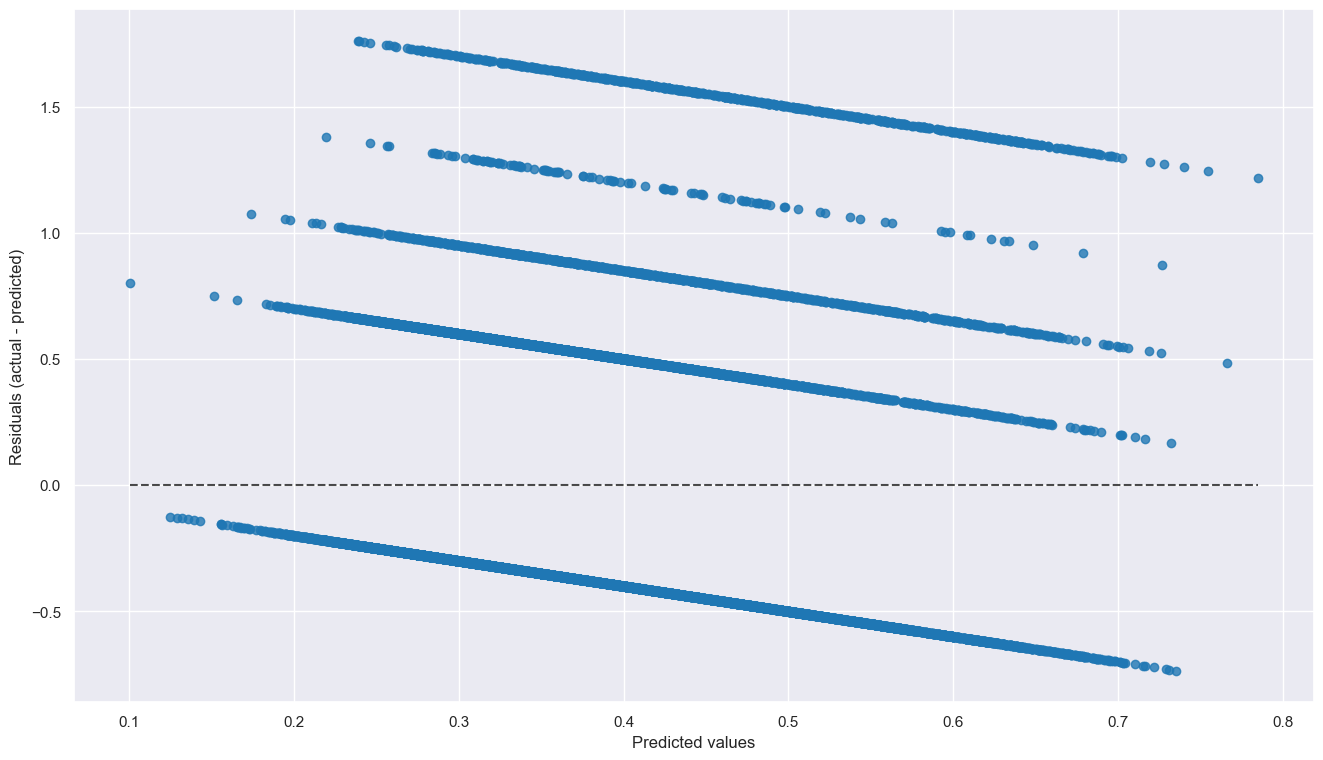

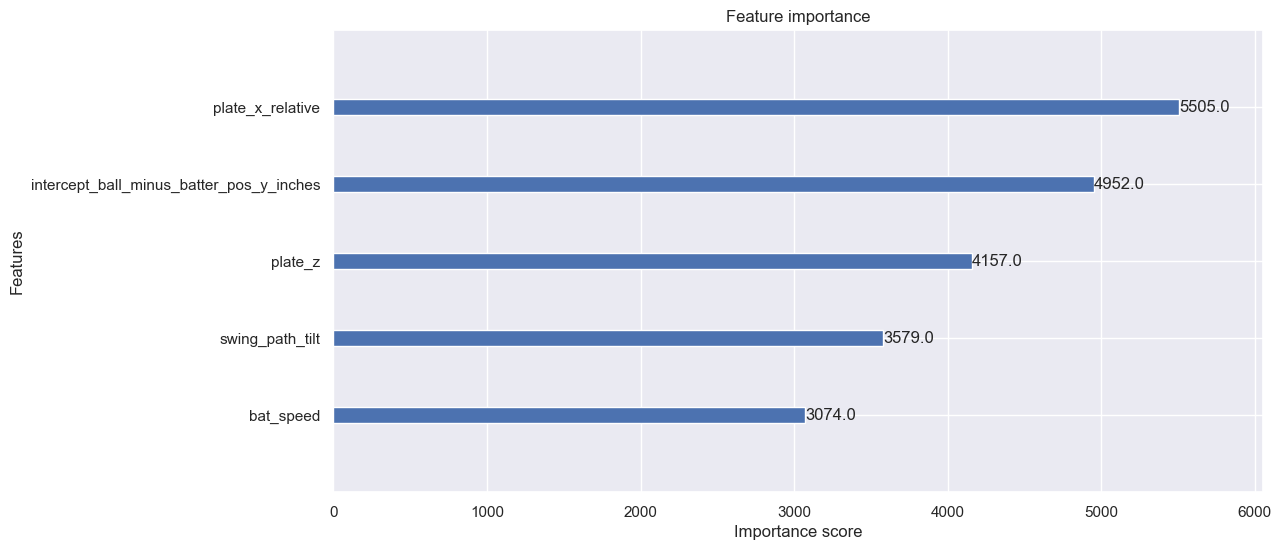

In [31]:
woba_xgb_6_features = [
    'bat_speed',
    'swing_path_tilt',
    'intercept_ball_minus_batter_pos_y_inches',
    'plate_x_relative',
    'plate_z'
]

woba_xgb_6 = train_and_evaluate_xgb(
    df=df_threshold,
    label='woba_value',
    features=woba_xgb_6_features
)

100% (12 of 12) |########################| Elapsed Time: 0:00:26 Time:  0:00:260:02


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     22.3394
Link Function:                     IdentityLink Log Likelihood:                                -99999.0453
Number of Samples:                        75072 AIC:                                           200044.7696
                                                AICc:                                          200044.7847
                                                GCV:                                                0.3258
                                                Scale:                                              0.3256
                                                Pseudo R-Squared:                                   0.0205
Feature Function                  Lam

/var/folders/np/dvwvz621751dvk0br_sg0vv00000gn/T/ipykernel_59994/3519869499.py:55: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  model.summary()


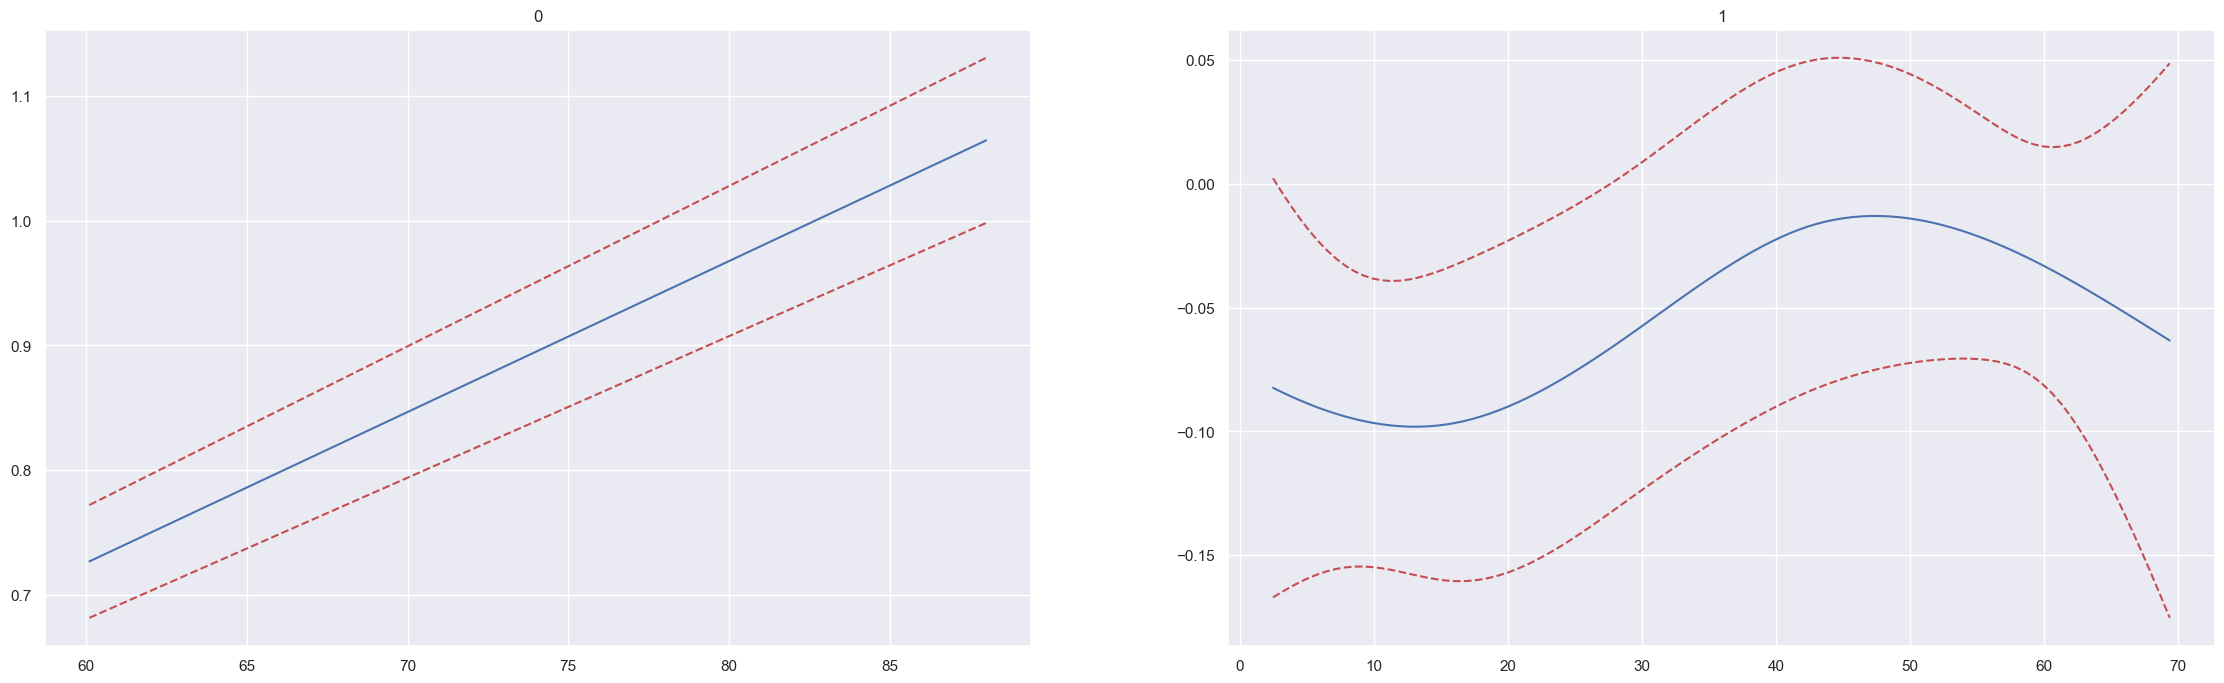

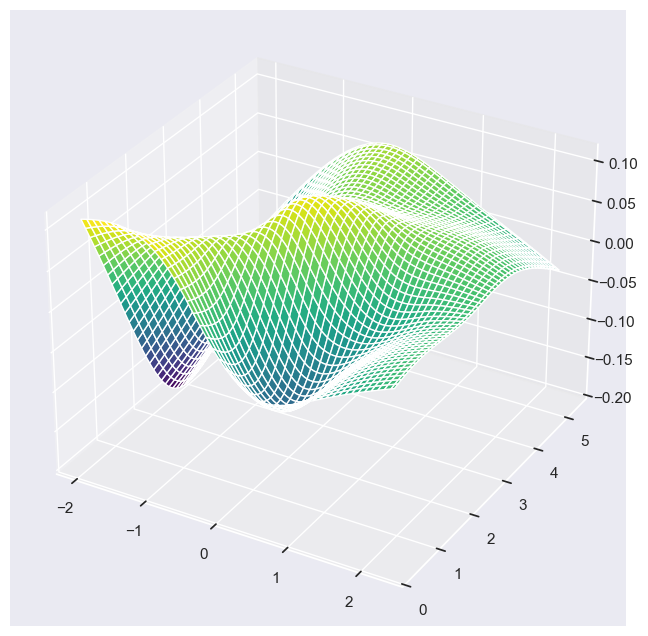


R2 score: 0.017

MAE score: 0.491

MSE score: 0.320


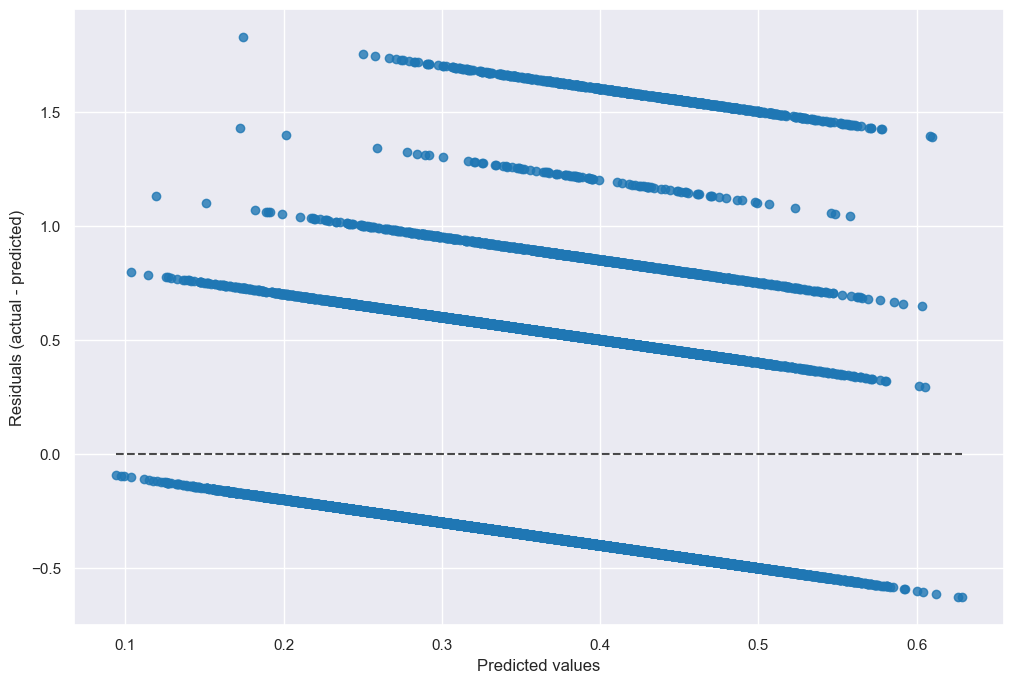

In [32]:
woba_gam_label_1 = 'woba_value'
woba_gam_features_1 = [
    'bat_speed',
    'swing_path_tilt',
    'plate_x_relative',
    'plate_z'
]
woba_gam_constraints_1 = [None, None, None]
woba_gam_lam_1 = np.logspace(-1, 1, 3)
woba_gam_model_1 = LinearGAM(
    l(0) +
    s(1, n_splines=8) +
    te(2, 3, n_splines=10)
)

woba_gam_1 = train_and_evaluate_gam(
    df=df_threshold,
    label=woba_gam_label_1,
    features=woba_gam_features_1,
    model=woba_gam_model_1,
    lam=woba_gam_lam_1,
    intercept=True,
    test_size=0.2
)

100% (6 of 6) |##########################| Elapsed Time: 0:00:12 Time:  0:00:120:01
/var/folders/np/dvwvz621751dvk0br_sg0vv00000gn/T/ipykernel_59994/3519869499.py:55: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  model.summary()


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     17.4754
Link Function:                     IdentityLink Log Likelihood:                               -309002.9665
Number of Samples:                        75072 AIC:                                           618042.8836
                                                AICc:                                          618042.8932
                                                GCV:                                               23.9676
                                                Scale:                                             23.9576
                                                Pseudo R-Squared:                                   0.4663
Feature Function                  Lam


R2 score: 0.468

MAE score: 3.845

MSE score: 23.766


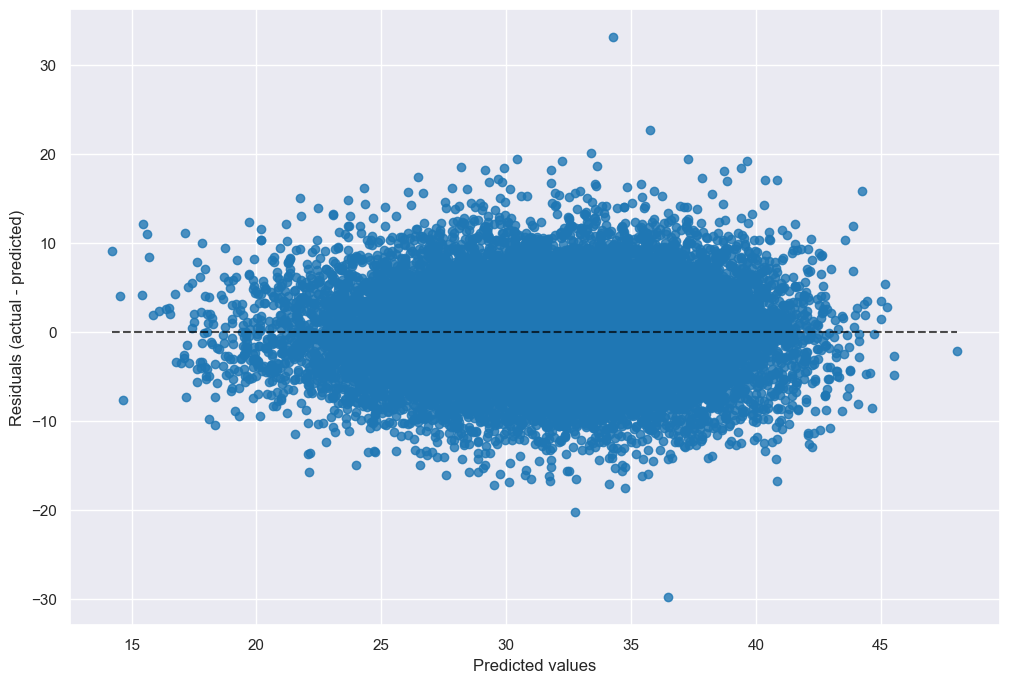

In [34]:
spt_gam_label_1 = 'swing_path_tilt'
spt_gam_features_1 = [
    'plate_x_relative',
    'plate_z'
]
spt_gam_constraints_1 = [None]
spt_gam_lam_1 = np.logspace(-1, 1, 3)
spt_gam_model_1 = LinearGAM(
    te(0, 1, n_splines=10)
)

spt_gam_1 = train_and_evaluate_gam(
    df=df_threshold,
    label=spt_gam_label_1,
    features=spt_gam_features_1,
    model=spt_gam_model_1,
    lam=spt_gam_lam_1,
    intercept=True,
    test_size=0.2
)

In [35]:
df_threshold['swing_path_tilt_pred'] = spt_gam_1.predict(df_threshold[spt_gam_features_1].to_numpy())
df_threshold['swing_path_tilt_resid'] = df_threshold['swing_path_tilt'] - df_threshold['swing_path_tilt_pred']

100% (12 of 12) |########################| Elapsed Time: 0:00:25 Time:  0:00:250:02


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     21.6359
Link Function:                     IdentityLink Log Likelihood:                                -99999.6245
Number of Samples:                        75072 AIC:                                           200044.5207
                                                AICc:                                           200044.535
                                                GCV:                                                0.3258
                                                Scale:                                              0.3256
                                                Pseudo R-Squared:                                   0.0205
Feature Function                  Lam

/var/folders/np/dvwvz621751dvk0br_sg0vv00000gn/T/ipykernel_59994/3519869499.py:55: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  model.summary()


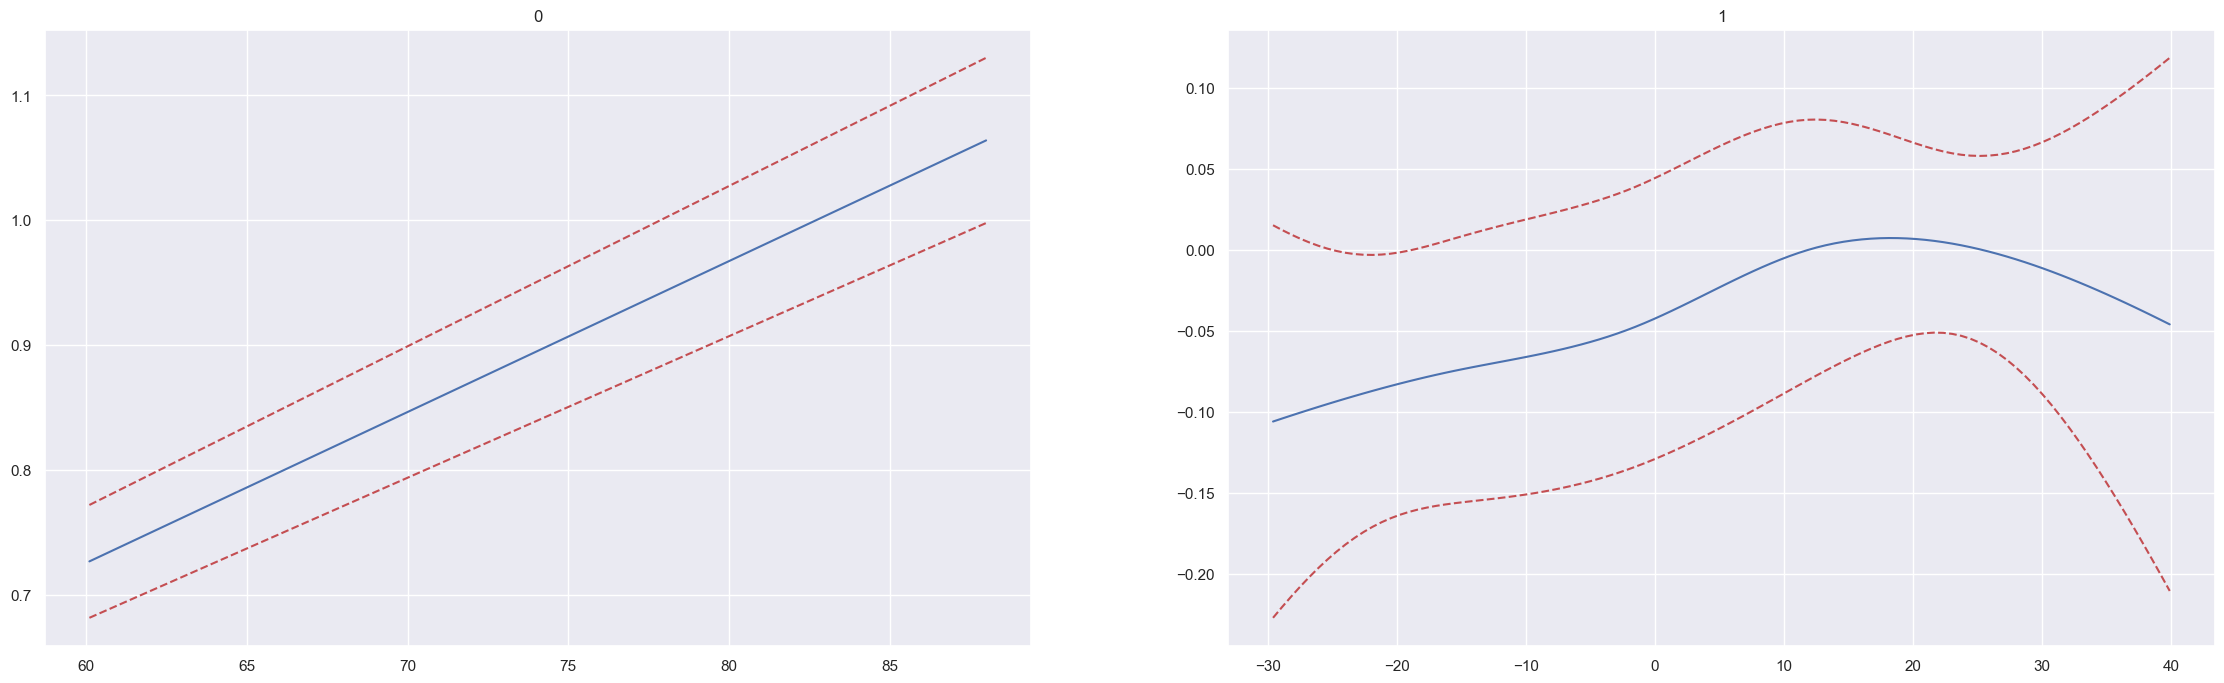

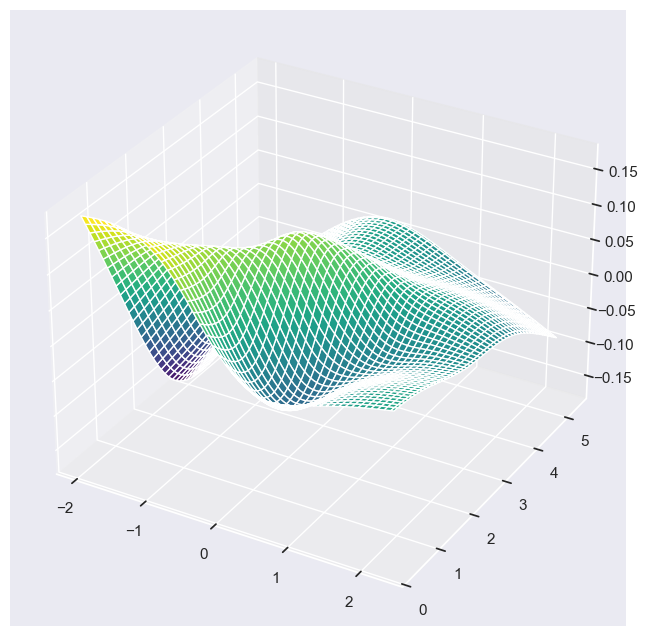


R2 score: 0.017

MAE score: 0.491

MSE score: 0.320


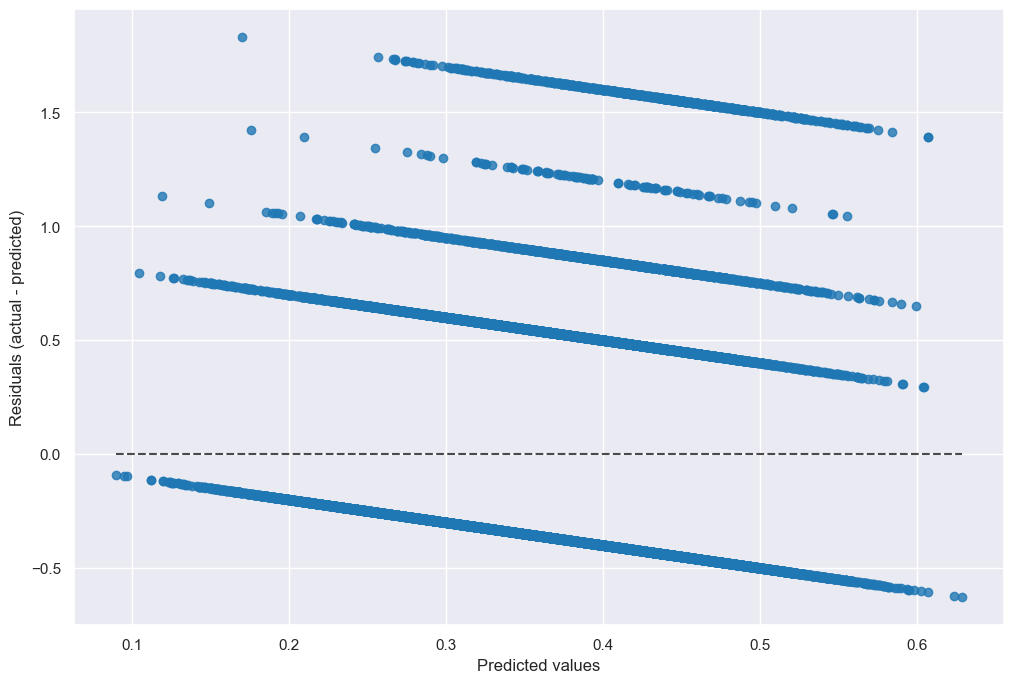

In [36]:
woba_gam_label_2 = 'woba_value'
woba_gam_features_2 = [
    'bat_speed',
    'swing_path_tilt_resid',
    'plate_x_relative',
    'plate_z'
]
woba_gam_constraints_2 = [None, None]
woba_gam_lam_2 = np.logspace(-1, 1, 3)
woba_gam_model_2 = LinearGAM(
    l(0) +
    s(1, n_splines=8) +
    te(2, 3, n_splines=10)
)

woba_gam_2 = train_and_evaluate_gam(
    df=df_threshold,
    label=woba_gam_label_2,
    features=woba_gam_features_2,
    model=woba_gam_model_2,
    lam=woba_gam_lam_2,
    intercept=True,
    test_size=0.2
)

100% (15 of 15) |########################| Elapsed Time: 0:00:22 Time:  0:00:220103


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     37.3228
Link Function:                     IdentityLink Log Likelihood:                               -100186.8801
Number of Samples:                        75044 AIC:                                           200450.4058
                                                AICc:                                           200450.446
                                                GCV:                                                0.3239
                                                Scale:                                              0.3236
                                                Pseudo R-Squared:                                    0.028
Feature Function                  Lam

/var/folders/np/dvwvz621751dvk0br_sg0vv00000gn/T/ipykernel_59994/3519869499.py:55: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  model.summary()


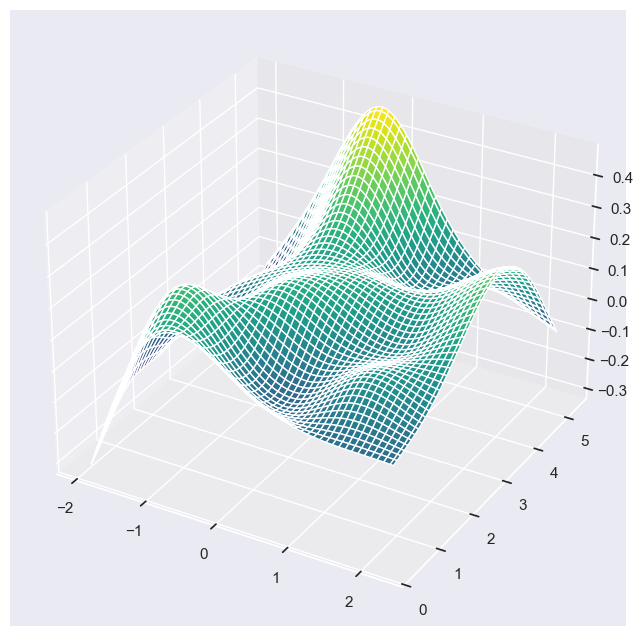


R2 score: 0.021

MAE score: 0.489

MSE score: 0.317


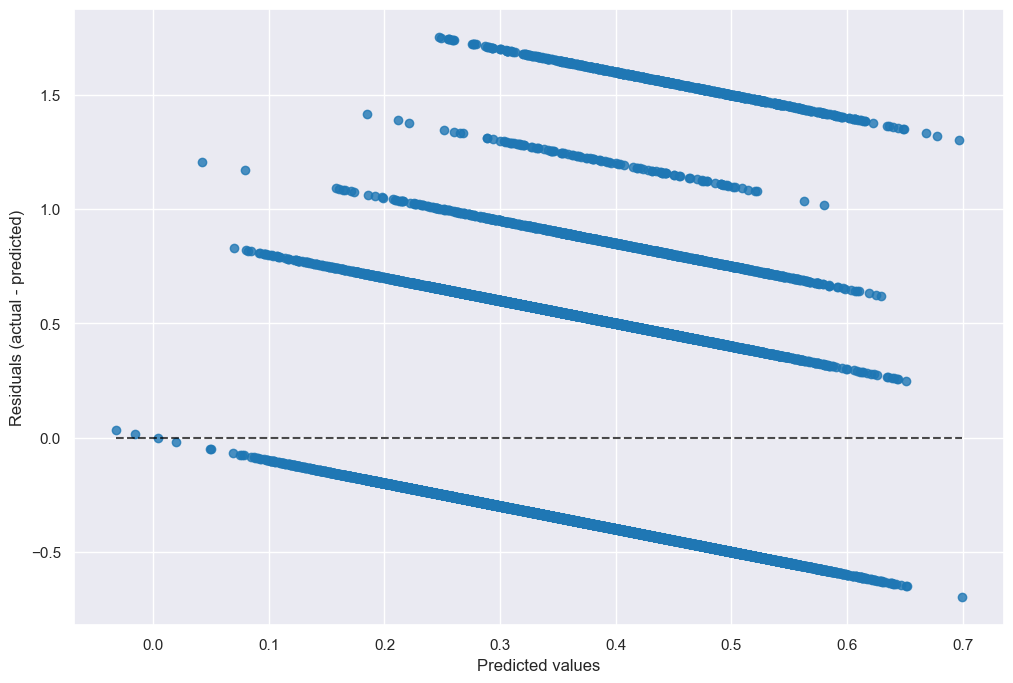

In [37]:
woba_gam_label_3 = 'woba_value'
woba_gam_features_3 = [
    'bat_speed',
    'swing_path_tilt',
    'intercept_ball_minus_batter_pos_y_inches',
    'plate_x_relative',
    'plate_z'
]
woba_gam_constraints_3 = [None, None, None, 'concave']
woba_gam_lam_3 = np.logspace(-1, 1, 3)
woba_gam_model_3 = LinearGAM(
    l(0) +
    s(1, n_splines=8) +
    s(2, n_splines=8) +
    te(3, 4, constraints='concave', n_splines=8)
)

woba_gam_3 = train_and_evaluate_gam(
    df=df_threshold,
    label=woba_gam_label_3,
    features=woba_gam_features_3,
    model=woba_gam_model_3,
    lam=woba_gam_lam_3,
    intercept=True
)

## Predictions

In [38]:
df_threshold['woba_pred_gam_2'] = woba_gam_2.predict(df_threshold[woba_gam_features_2].to_numpy())
df_threshold['woba_pred_xgb_4'] = woba_xgb_4.predict(df_threshold[woba_xgb_4_features].to_numpy())
df_threshold['woba_pred_xgb_6'] = woba_xgb_6.predict(df_threshold[woba_xgb_6_features].to_numpy())

In [39]:
df_threshold['swing_plus'] = zscore(df_threshold['woba_pred_xgb_6'].astype(float)) * 25 + 100

In [47]:
df_summary = df_threshold.groupby(['batter', 'batter_name']).agg(
    n_events=('event_id', 'count'),
    swing_plus=('swing_plus', 'mean'),
    wobacon_pred=('woba_pred_xgb_6', 'mean'),
    wobacon=('woba_value', 'mean'),
    bat_speed=('bat_speed', 'mean'),
    spt_resid=('swing_path_tilt_resid', 'mean'),
    spt=('swing_path_tilt', 'mean'),
    plate_x=('plate_x_relative', 'mean'),
    plate_z=('plate_z', 'mean'),
    intercept_ball_minus_batter_pos_y_inches=('intercept_ball_minus_batter_pos_y_inches', 'mean'),
    attack_angle=('attack_angle', 'mean'),
    attack_direction=('attack_direction', 'mean')
).round(3).query('n_events >= 10').sort_values(by='wobacon', ascending=False)

In [48]:
df_summary['wobacon_diff'] = round(df_summary['wobacon'] - df_summary['wobacon_pred'], 4)

In [50]:
df_summary.sort_values(by='swing_plus', ascending=False)

n_events  swing_plus  wobacon_pred  wobacon  bat_speed  \
batter batter_name                                                             
695578 James Wood          303     122.752         0.469    0.498     76.307   
592450 Aaron Judge         284     120.535         0.460    0.607     76.313   
701762 Nick Kurtz          198     119.920         0.457    0.615     77.892   
670242 Matt Wallner        171     119.743         0.456    0.472     77.195   
671213 Triston Casas        70     118.504         0.451    0.294     74.754   
...                        ...         ...           ...      ...        ...   
664068 Scott Kingery        13      82.898         0.304    0.165     69.631   
660688 Keibert Ruiz        207      82.728         0.303    0.292     66.186   
669397 Nick Allen          207      82.376         0.301    0.272     65.809   
676070 Jacob Amaya          44      81.902         0.299    0.110     67.320   
670032 Nicky Lopez          18      79.395         0.289    0.100     68.828   

                      spt_resid     spt  plate_x  plate_z  \
batter batter_name                                          
695578 James Wood         9.271  40.536   -0.067    2.554   
592450 Aaron Judge        8.399  38.580   -0.009    2.662   
701762 Nick Kurtz         7.102  38.822    0.008    2.451   
670242 Matt Wallner      -2.752  28.242    0.143    2.467   
671213 Triston Casas      5.778  35.778    0.170    2.583   
...                         ...     ...      ...      ...   
664068 Scott Kingery      0.787  33.072    0.268    2.191   
660688 Keibert Ruiz       2.081  33.491    0.201    2.363   
669397 Nick Allen        -3.674  29.943   -0.055    2.253   
676070 Jacob Amaya       -1.548  30.130    0.013    2.465   
670032 Nicky Lopez       -7.826  25.702   -0.213    2.361   

                      intercept_ball_minus_batter_pos_y_inches  attack_angle  \
batter batter_name                                                             
695578 James Wood                                       30.630         6.788   
592450 Aaron Judge                                      29.191        11.724   
701762 Nick Kurtz                                       24.006        12.203   
670242 Matt Wallner                                     37.853        11.535   
671213 Triston Casas                                    29.369        10.694   
...                                                        ...           ...   
664068 Scott Kingery                                    34.662        16.904   
660688 Keibert Ruiz                                     34.162         6.675   
669397 Nick Allen                                       32.557         7.371   
676070 Jacob Amaya                                      26.849         9.285   
670032 Nicky Lopez                                      28.355         7.448   

                      attack_direction  wobacon_diff  
batter batter_name                                    
695578 James Wood                4.945         0.029  
592450 Aaron Judge              -3.880         0.147  
701762 Nick Kurtz                4.516         0.158  
670242 Matt Wallner             -5.397         0.016  
671213 Triston Casas             1.668        -0.157  
...                                ...           ...  
664068 Scott Kingery            -4.937        -0.139  
660688 Keibert Ruiz             -2.794        -0.011  
669397 Nick Allen                0.156        -0.029  
676070 Jacob Amaya               3.545        -0.189  
670032 Nicky Lopez               6.186        -0.189  

[536 rows x 13 columns]

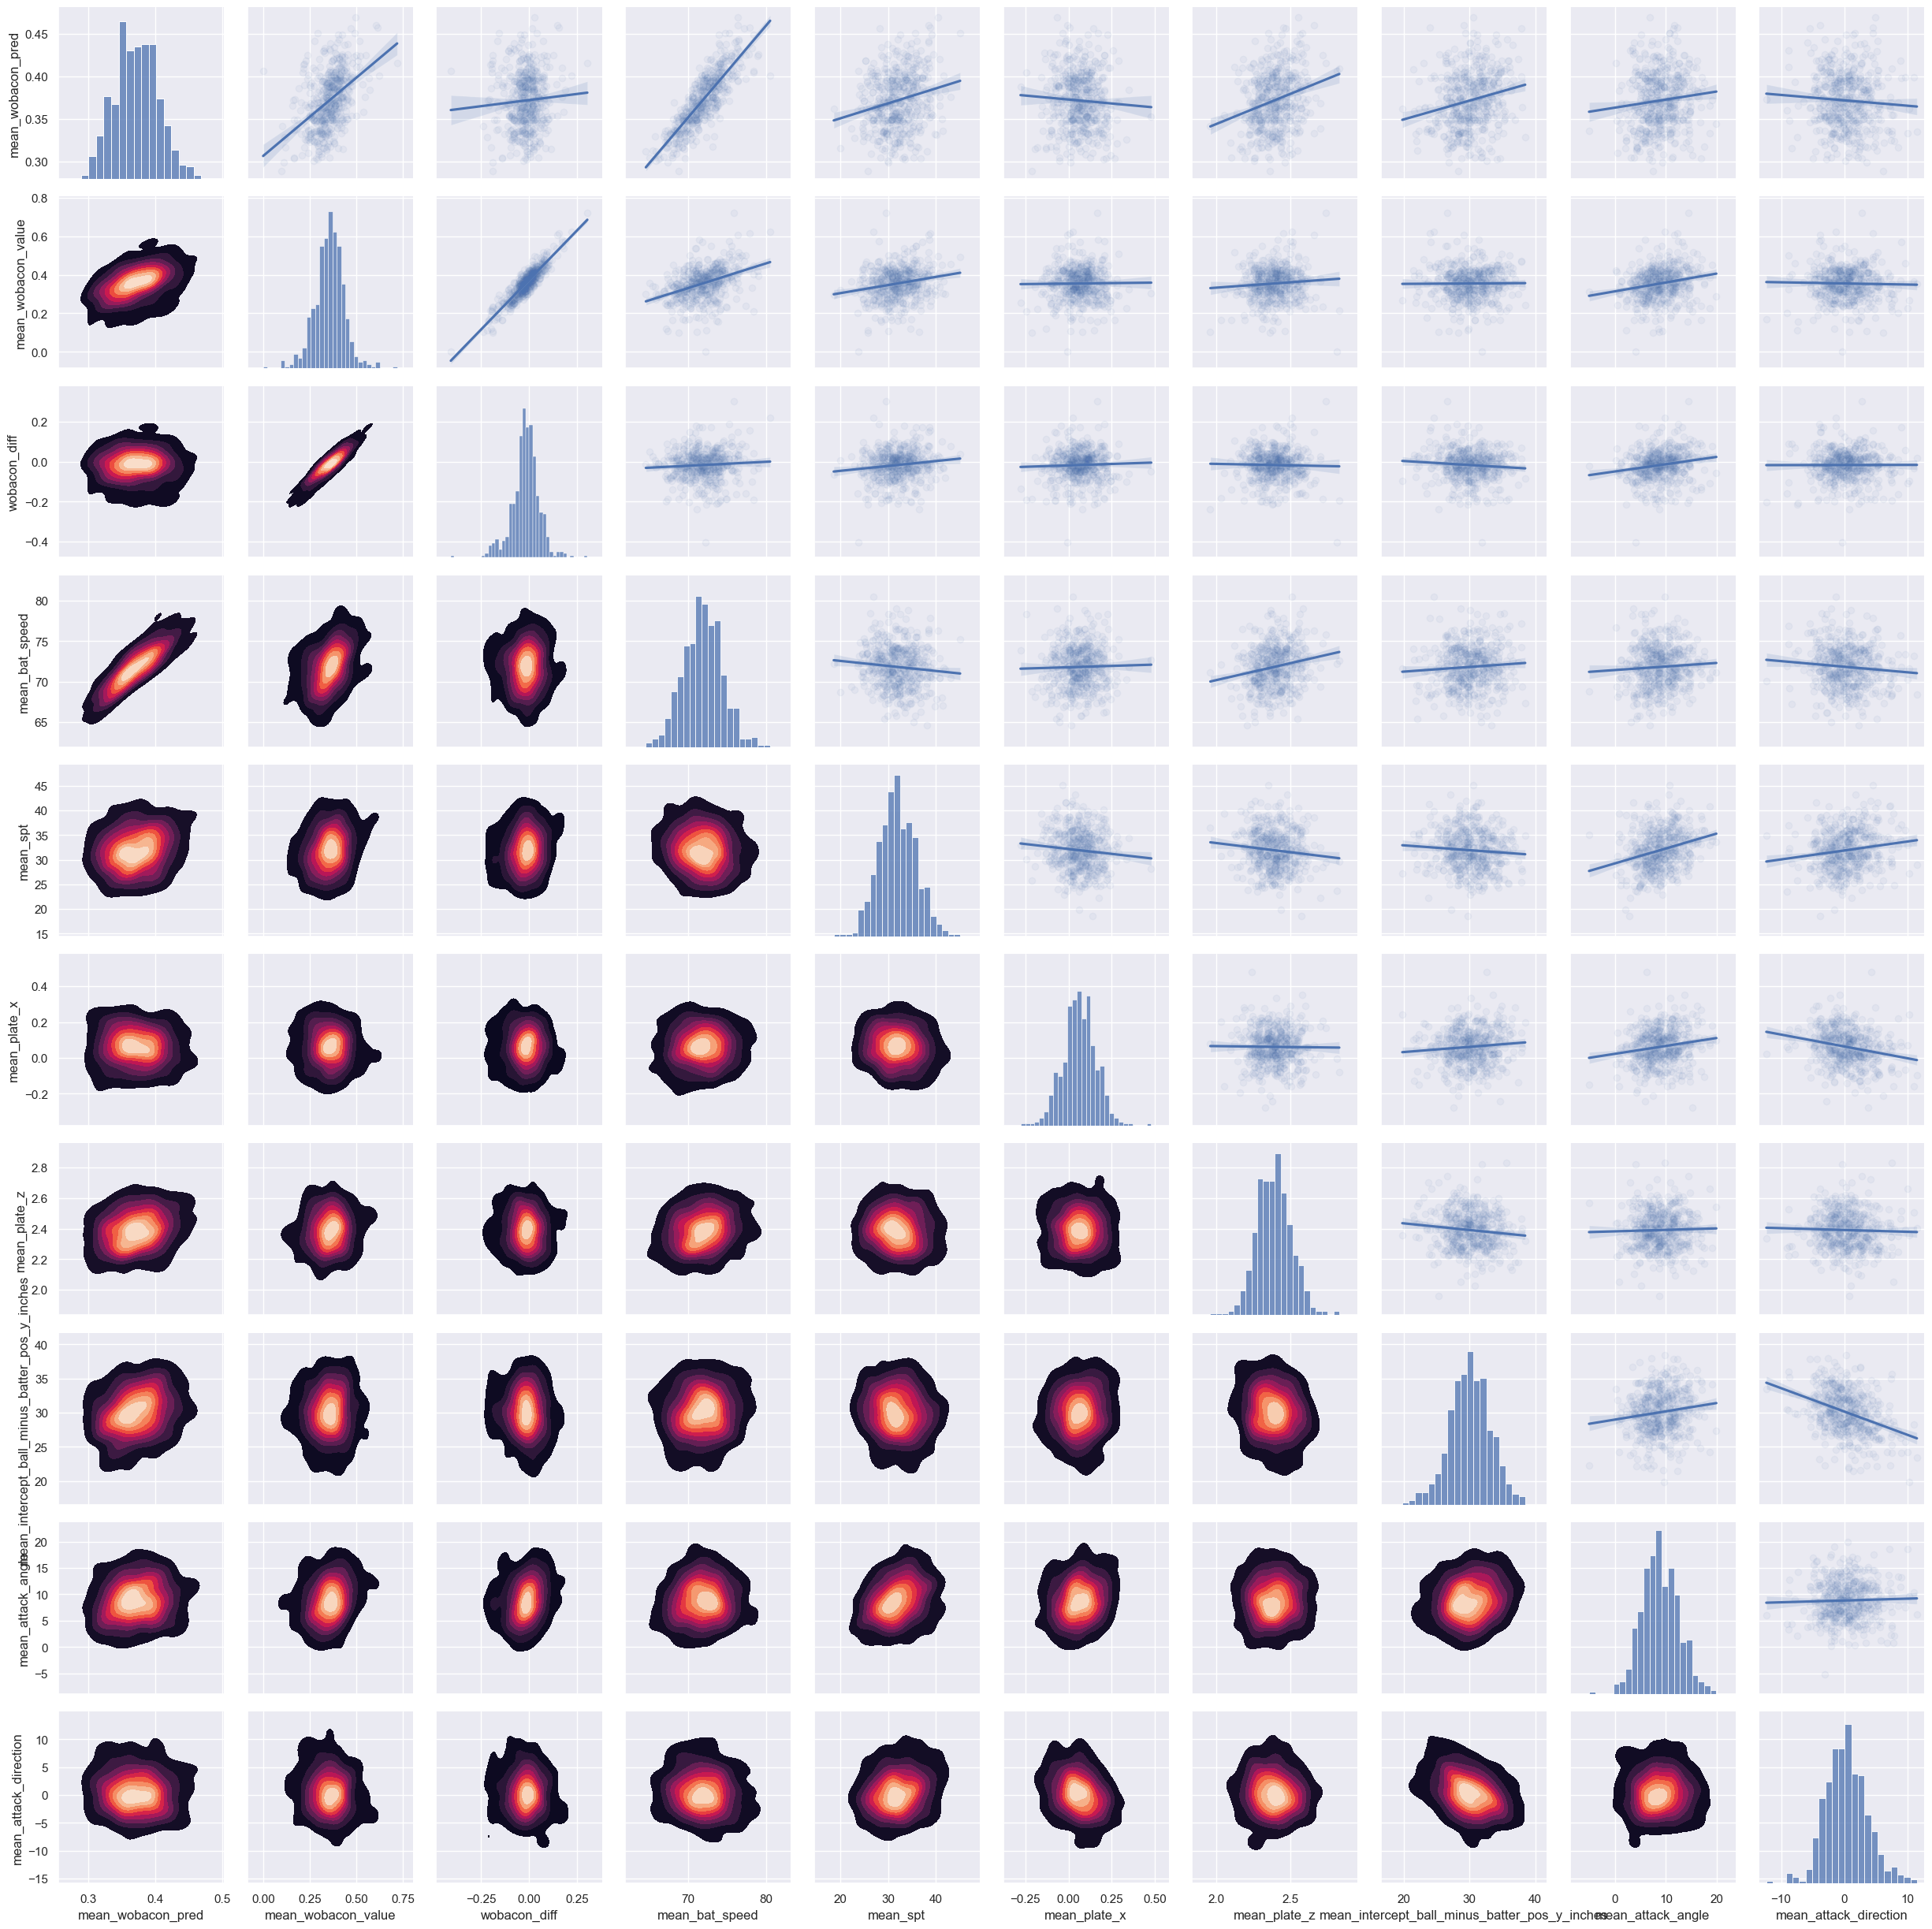

In [43]:
summary_pair_columns = [
    'mean_wobacon_pred',
    'mean_wobacon_value',
    'wobacon_diff',
    'mean_bat_speed',
    'mean_spt',
    'mean_plate_x',
    'mean_plate_z',
    'mean_intercept_ball_minus_batter_pos_y_inches',
    'mean_attack_angle',
    'mean_attack_direction'
]
df_summary_pair = df_summary[summary_pair_columns]

summary_pair_g = sns.PairGrid(df_summary_pair)
summary_pair_g = summary_pair_g.map_upper(sns.regplot, scatter_kws={'alpha': 0.05})
summary_pair_g = summary_pair_g.map_lower(sns.kdeplot, cmap='rocket', fill=True, thresh=0.05, n_levels=10)
summary_pair_g = summary_pair_g.map_diag(sns.histplot)

In [44]:
df_summary.to_csv(os.path.join(os.pardir, 'data', 'swing_plus_summary.csv'))

In [45]:
df_threshold.sort_values(by='swing_plus', ascending=False)

event_id   game_date  game_year  batter pitcher stand  plate_x  \
25928  777840.20.1  2025-05-20       2025  682985  607200     L     0.54   
91683  778458.53.5  2025-04-04       2025  682985  669060     L     0.52   
9033   777783.43.3  2025-05-25       2025  657757  680885     L     0.79   
46889  778026.26.4  2025-05-06       2025  695578  682847     L     0.56   
42632  777725.40.6  2025-05-29       2025  701358  669358     R    -0.38   
...            ...         ...        ...     ...     ...   ...      ...   
46381  777721.38.7  2025-05-30       2025  624585  682847     R    -1.11   
34258  778538.20.4  2025-03-29       2025  592885  608331     L     1.13   
25425  777581.41.5  2025-06-09       2025  543807  669467     R    -1.10   
5014   777416.58.1  2025-06-21       2025  660271  678606     L     1.06   
5015   777416.58.1  2025-06-21       2025  660271  678606     L     1.06   

       plate_z  bat_speed  swing_length  ...  plate_x_relative      plate_pos  \
25928     2.31       81.8           7.9  ...             -0.54  [-0.54, 2.31]   
91683     2.09       81.3           7.5  ...             -0.52  [-0.52, 2.09]   
9033      1.43       78.2           8.0  ...             -0.79  [-0.79, 1.43]   
46889     2.17       81.2           8.2  ...             -0.56  [-0.56, 2.17]   
42632     2.10       81.7           8.1  ...             -0.38   [-0.38, 2.1]   
...        ...        ...           ...  ...               ...            ...   
46381     2.22       67.1           6.2  ...             -1.11  [-1.11, 2.22]   
34258     2.32       63.5           5.9  ...             -1.13  [-1.13, 2.32]   
25425     1.81       63.9           6.4  ...             -1.10   [-1.1, 1.81]   
5014      2.31       66.8           6.9  ...             -1.06  [-1.06, 2.31]   
5015      2.31       66.8           6.9  ...             -1.06  [-1.06, 2.31]   

       plate_z_binned  plate_x_binned  swing_path_tilt_pred  \
25928            2.26          -0.643               36.0133   
91683            2.02          -0.536               37.4887   
9033              NaN             NaN               42.8318   
46889            2.10          -0.643               37.1364   
42632            2.02          -0.429               36.6858   
...               ...             ...                   ...   
46381            2.18             NaN               39.1145   
34258            2.26             NaN               38.4286   
25425            1.78             NaN               41.8549   
5014             2.26             NaN               38.2601   
5015             2.26             NaN               38.2601   

       swing_path_tilt_resid  woba_pred_gam_2 woba_pred_xgb_4 woba_pred_xgb_6  \
25928                14.4006           0.5632          0.6930          0.8645   
91683                12.2046           0.5698          0.6961          0.8599   
9033                  1.8399           0.5181          0.5884          0.8398   
46889                 9.3026           0.5511          0.6942          0.8323   
42632                 8.2930           0.5730          0.7220          0.8250   
...                      ...              ...             ...             ...   
46381                 8.7937           0.2892          0.2474          0.1025   
34258                 5.7142           0.2188          0.2123          0.1006   
25425                11.6261           0.3196          0.2572          0.0944   
5014                  2.2873           0.2576          0.2137          0.0933   
5015                  2.2873           0.2576          0.2137          0.0933   

       swing_plus  
25928    218.2818  
91683    217.1665  
9033     212.3196  
46889    210.5090  
42632    208.7418  
...           ...  
46381     34.3684  
34258     33.8998  
25425     32.4030  
5014      32.1426  
5015      32.1426  

[93841 rows x 29 columns]